## Prediction of women's shoe price

**Background:** This dataset has about 10,000 records of woman's shoes and its prices.
    
**Data Source:** https://data.world/datafiniti/womens-shoe-prices

**Objective:** To predict the women's shoe price from the brand, model and other specifics
    
**Performance metric for machine learning model:** Primary: Mean-squared, Secondary: Mean deviation error

In [716]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 
import re
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
import warnings
warnings.filterwarnings("ignore")
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.linear_model import SGDRegressor

## Reading data from CSV file to SQL database

In [282]:
file1 = pd.read_csv(r"7003_1.csv")
file2 = pd.read_csv(r"Datafiniti_Womens_Shoes_Jun19.csv")
file3 = pd.read_csv(r"Datafiniti_Womens_Shoes.csv")

In [283]:
file1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19045 entries, 0 to 19044
Data columns (total 47 columns):
id                     19045 non-null object
asins                  2208 non-null object
brand                  18412 non-null object
categories             19045 non-null object
colors                 11889 non-null object
count                  0 non-null float64
dateAdded              19045 non-null object
dateUpdated            19045 non-null object
descriptions           10780 non-null object
dimension              2418 non-null object
ean                    9816 non-null float64
features               14108 non-null object
flavors                0 non-null float64
imageURLs              17840 non-null object
isbn                   0 non-null float64
keys                   19045 non-null object
manufacturer           8656 non-null object
manufacturerNumber     15903 non-null object
merchants              13688 non-null object
name                   19045 non-null object
pri

In [284]:
file2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 32 columns):
id                     10000 non-null object
dateAdded              10000 non-null object
dateUpdated            10000 non-null object
asins                  5 non-null object
brand                  10000 non-null object
categories             10000 non-null object
primaryCategories      10000 non-null object
colors                 10000 non-null object
dimension              465 non-null object
ean / upc              10000 non-null int64
imageURLs              2643 non-null object
keys                   10000 non-null object
manufacturer           1362 non-null object
manufacturerNumber     1431 non-null object
name                   10000 non-null object
prices.amountMax       10000 non-null float64
prices.amountMin       10000 non-null float64
prices.availability    10000 non-null bool
prices.color           10000 non-null object
prices.condition       0 non-null float64
price

In [285]:
file3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 34 columns):
id                     10000 non-null object
dateAdded              10000 non-null object
dateUpdated            10000 non-null object
asins                  3 non-null object
brand                  10000 non-null object
categories             10000 non-null object
primaryCategories      10000 non-null object
colors                 2631 non-null object
dimension              117 non-null object
ean                    671 non-null float64
imageURLs              10000 non-null object
keys                   10000 non-null object
manufacturer           527 non-null object
manufacturerNumber     2482 non-null object
name                   10000 non-null object
prices.amountMax       10000 non-null float64
prices.amountMin       10000 non-null float64
prices.availability    434 non-null object
prices.color           10000 non-null object
prices.condition       438 non-null object
price

In [286]:
file1_cols = [i for i in file1.columns]
file2_cols = [i for i in file2.columns]
file3_cols = [i for i in file3.columns]

In [287]:
print("Total number of columns in File 1: ", len(file1_cols))
print("Total number of columns in File 2: ", len(file2_cols))
print("Total number of columns in File 3: ", len(file3_cols))

Total number of columns in File 1:  47
Total number of columns in File 2:  32
Total number of columns in File 3:  34


File 3 is updated file of file 2. We will use file1 and file 2 for our analysis

In [288]:
file3.sample(5).loc[:,'prices.color':]

,prices.color,prices.condition,prices.currency,prices.dateAdded,prices.dateSeen,prices.isSale,prices.merchant,prices.offer,prices.returnPolicy,prices.shipping,prices.size,prices.sourceURLs,sizes,sourceURLs,upc,weight
8093,Gray Hot Punch,NaN,USD,2018-01-05T17:58:22Z,"2017-12-31T14:34:00.000Z,2017-12-12T13:05:00.0...",False,NaN,NaN,NaN,NaN,11,https://www.kohls.com/product/prd-2734966/nike...,"10.5 WIDE,7 WIDE,7.5 WIDE,8 WIDE,8.5 WIDE,9 WI...",https://www.kohls.com/product/prd-2734966/nike...,"884500153103,884500152984,884500152991,8845001...",NaN
3590,Coral Gray,NaN,USD,2018-02-01T07:34:54Z,"2018-01-16T10:45:00.000Z,2018-01-17T13:00:00.0...",False,NaN,NaN,NaN,NaN,12 WIDE,https://www.kohls.com/product/prd-2757299/ryka...,"5 MED,5.5 MED,6 MED,6.5 MED,7 MED,7.5 MED,8 ME...",https://www.kohls.com/product/prd-2757299/ryka...,"727682354343,727682354589,727682355067,7276823...",NaN
2838,Black Snake,NaN,USD,2018-01-09T14:32:28Z,"2018-01-06T18:55:00.000Z,2018-01-07T13:23:00.000Z",False,NaN,NaN,NaN,NaN,8.5 MED,https://www.kohls.com/product/prd-2671544/life...,"5 MED,5.5 MED,6 MED,6.5 MED,7 MED,7.5 MED,8 ME...",https://www.kohls.com/product/prd-2671544/life...,"727679302074,727679301855,727679301190,7276858...",NaN
3304,Black Knit,NaN,USD,2018-01-02T15:36:49Z,"2017-12-18T12:16:00.000Z,2017-12-24T12:21:00.0...",False,NaN,NaN,NaN,NaN,11 MED,https://www.kohls.com/product/prd-2928036/dr-s...,"6 MED,6.5 MED,7 MED,7.5 MED,8 MED,8.5 MED,9 ME...",https://www.kohls.com/product/prd-2928036/dr-s...,"727681052813,727679380195,727682576707,7276938...",NaN
2304,Black,NaN,USD,2017-12-29T18:46:20Z,2017-12-10T01:32:00.000Z,False,NaN,NaN,NaN,NaN,7.5 WIDE,https://www.kohls.com/product/prd-2907320/crof...,"7.5,8,8.5,9,9.5,10,5,6,6.5,7,11,5.5,9.5 WIDE,5...",https://www.kohls.com/product/prd-2907320/crof...,"400740369243,400740369250,400740369267,4007403...",NaN


Let us explore file 3 first as it has information more specific to women's shoes

Create a SQLlite database and create a table named shoes that contains the contents from file3

In [289]:
# create connection to database
connection = sqlite3.connect("womensshoes.db") 
# cursor  
crsr = connection.cursor() 

file3.to_sql('shoes', connection, if_exists='replace', index = False) 

In [290]:
df = pd.read_sql_query("select * from shoes;", connection)
df.columns

Index(['id', 'dateAdded', 'dateUpdated', 'asins', 'brand', 'categories',
       'primaryCategories', 'colors', 'dimension', 'ean', 'imageURLs', 'keys',
       'manufacturer', 'manufacturerNumber', 'name', 'prices.amountMax',
       'prices.amountMin', 'prices.availability', 'prices.color',
       'prices.condition', 'prices.currency', 'prices.dateAdded',
       'prices.dateSeen', 'prices.isSale', 'prices.merchant', 'prices.offer',
       'prices.returnPolicy', 'prices.shipping', 'prices.size',
       'prices.sourceURLs', 'sizes', 'sourceURLs', 'upc', 'weight'],
      dtype='object')

The dataset contains maximum and minimum price for shoes. Let us take the average of these prices and use it as target feature

In [291]:
df['average_price']= (df['prices.amountMax'] + df['prices.amountMin'])/2
df.head(2)

,id,dateAdded,dateUpdated,asins,brand,categories,primaryCategories,colors,dimension,ean,...,prices.offer,prices.returnPolicy,prices.shipping,prices.size,prices.sourceURLs,sizes,sourceURLs,upc,weight,average_price
0,AVpfEf_hLJeJML431ueH,2015-05-04T12:13:08Z,2018-01-29T04:38:43Z,None,Naturalizer,"Clothing,Shoes,Women's Shoes,All Women's Shoes...",Shoes,"Silver,Cream Watercolor Floral",None,NaN,...,None,None,None,S,https://www.overstock.com/Clothing-Shoes/Women...,"6W,9W,7.5W,12W,8.5M,9N,9M,9.5M,10.5M,10W,8.5W,...",https://www.walmart.com/ip/Naturalizer-Danya-W...,017136472311,None,55.990
1,AVpi74XfLJeJML43qZAc,2017-01-27T01:23:39Z,2018-01-03T05:21:54Z,None,MUK LUKS,"Clothing,Shoes,Women's Shoes,Women's Casual Sh...",Shoes,Grey,None,3.397705e+10,...,None,None,Standard,6,https://www.walmart.com/ip/MUK-LUKS-Womens-Jan...,"10,7,6,9,8",https://www.walmart.com/ip/MUK-LUKS-Womens-Jan...,033977045743,None,41.125


## Split data into train and test 

In [292]:
X = df[df.columns[:-1]]
y = df.average_price

In [293]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=.7, test_size=0.3, random_state = 42)
print(X_train.shape)

(7000, 34)


In [294]:
X_train_backup = X_train.copy()

## EDA

In [295]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 9069 to 7270
Data columns (total 34 columns):
id                     7000 non-null object
dateAdded              7000 non-null object
dateUpdated            7000 non-null object
asins                  2 non-null object
brand                  7000 non-null object
categories             7000 non-null object
primaryCategories      7000 non-null object
colors                 1874 non-null object
dimension              81 non-null object
ean                    475 non-null float64
imageURLs              7000 non-null object
keys                   7000 non-null object
manufacturer           367 non-null object
manufacturerNumber     1762 non-null object
name                   7000 non-null object
prices.amountMax       7000 non-null float64
prices.amountMin       7000 non-null float64
prices.availability    319 non-null object
prices.color           7000 non-null object
prices.condition       321 non-null object
prices.currency 

Observation:
    - Most of the features (>85%) are object or categorical type
    - Only 4 numerical features
    - Feature prices.returnPolicy does not contain any information and it can be removed
    - Feature asins has only 2 non-null values. This feature can also be removed
    - Date columns are present which can be converted to pandas timestamp type

In [296]:
# Features to remove
features_remove = {'prices.returnPolicy', 'asins'}

In [297]:
X_train.describe()

,ean,prices.amountMax,prices.amountMin,prices.isSale
count,4.750000e+02,7000.000000,7000.000000,7000.000000
mean,7.729304e+11,69.321727,51.071033,0.018286
std,1.854372e+11,19.423304,20.986210,0.133992
min,3.397705e+10,5.870000,4.960000,0.000000
25%,7.276810e+11,59.990000,37.490000,0.000000
50%,8.701920e+11,64.990000,49.990000,0.000000
75%,8.860660e+11,79.990000,59.990000,0.000000
max,8.898850e+11,359.950000,359.950000,1.000000


In [298]:
### Looking only at non-null features

non_null_df = X_train.loc[:,X_train.columns[X_train.isnull().sum() == 0]]
non_null_df.describe(include = 'all')

,id,dateAdded,dateUpdated,brand,categories,primaryCategories,imageURLs,keys,name,prices.amountMax,prices.amountMin,prices.color,prices.currency,prices.dateSeen,prices.isSale,prices.size,prices.sourceURLs,sizes,sourceURLs
count,7000,7000,7000,7000,7000,7000,7000,7000,7000,7000.000000,7000.000000,7000,7000,7000,7000.000000,7000,7000,7000,7000
unique,611,416,462,119,199,2,611,611,610,NaN,NaN,497,1,3085,NaN,79,694,314,611
top,AV46uYe4glJLPUi8VW57,2017-11-10T19:33:19Z,2018-02-01T07:36:18Z,journee collection,"Womens,Shoes,Boots,Journee Collection",Shoes,https://media.kohlsimg.com/is/image/kohls/2734...,"886548735839,883212328021,886548745760,8844972...",Nike Flex Experience 6 Women's Running Shoes,NaN,NaN,Black,USD,"2018-01-16T11:37:00.000Z,2018-01-17T12:17:00.0...",NaN,6,https://www.kohls.com/product/prd-2734966/nike...,"5 MED,5.5 MED,6 MED,6.5 MED,7 MED,7.5 MED,8 ME...",https://www.kohls.com/product/prd-2734966/nike...
freq,131,181,165,1535,595,6580,131,131,131,NaN,NaN,1399,7000,33,NaN,312,131,513,131
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.321727,51.071033,NaN,NaN,NaN,0.018286,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.423304,20.986210,NaN,NaN,NaN,0.133992,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.870000,4.960000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.990000,37.490000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.990000,49.990000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.990000,59.990000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN


- There are only 2 unique values for the feature primaryCategories.
- All shoe price is in currency USD. The feature prices.currency can be removed

In [299]:
#What are the two unique values of primaryCategories?
non_null_df.primaryCategories.unique()

array(['Shoes,Shoes', 'Shoes'], dtype=object)

PrimaryCategories feature contains - Shoes --> zero variance - this feature will be removed


In [300]:
#What are categories and how is it different from primaryCategories?
print(non_null_df.categories.unique())
#non_null_df[['brand', 'categories']]
non_null_df.groupby('brand')['categories'].nunique().sort_values(ascending = False)

['Womens,Shoes,Athletic Shoes,Sneakers,ASICS' 'Womens,Shoes,Boots'
 'Womens,Shoes,Flats,Journee Collection' 'Womens,Shoes,Flats,Croft,Barrow'
 'Womens,Shoes,Boots,A2 by Aerosoles'
 "Womens,Shoes,Clogs,Mules,Spring Step,Clothing,Men's Shoes,Men's Casual Shoes,Other Slip-Ons"
 'Womens,Shoes,Pumps,Heels,LifeStride' 'Womens,Shoes,Sandals,LifeStride'
 'Womens,Shoes,Boots,Journee Collection'
 'Womens,Shoes,Clogs,Mules,Style Charles by Charles David'
 'Womens,Shoes,Sandals,Style Charles by Charles David'
 "Womens,Shoes,Sandals,LifeStride,Clothing,Women's Shoes,All Women's Shoes"
 "Womens,Shoes,Boots,Dr. Scholl's,Women's Shoes,Clothing,All Women's Shoes"
 'Womens,Shoes,Athletic Shoes,Sneakers,New Balance'
 'Womens,Shoes,Flats,LifeStride'
 "Women's Trail Running Shoes,Women's Footwear,Women's Running Shoes"
 "Womens,Shoes,Boots,Candie's" 'Womens,Shoes,Flats'
 'Womens,Shoes,Flats,Seven7'
 "Womens,Shoes,Athletic Shoes,Sneakers,ASICS,Clothing,Women's Shoes,Women's Casual Shoes"
 'Womens,Shoes,Pump

brand
journee collection    10
easy street           10
a2 by aerosoles        8
lifestride             8
SKECHERS               7
                      ..
lugz                   1
Native Shoes           1
Mo Mo                  1
nyla                   1
vans                   1
Name: categories, Length: 119, dtype: int64

- "Categories" features has information about the type of shoes - for example, athletic shoes or sandals. In some records, it just contains the brand name. This feature togther with brand name can be used to obtain the different types of footwaer sold by a company. 

- Brand "journee collection" has the highest number of different categories. The different categories are not straightforward but contained within the string:

In [301]:
non_null_df[non_null_df.brand == 'journee collection'].categories.unique()

array(['Womens,Shoes,Flats,Journee Collection',
       'Womens,Shoes,Boots,Journee Collection',
       'Womens,Shoes,Pumps,Heels,Journee Collection',
       "Womens,Shoes,Pumps,Heels,Journee Collection,Clothing,Women's Shoes,Women's Dress Shoes,All Women's Shoes",
       'Womens,Shoes,Clogs,Mules,Journee Collection',
       'Womens,Shoes,Sandals,Journee Collection',
       "Womens,Shoes,Boots,Journee Collection,Clothing,Women's Shoes,All Women's Shoes",
       "Womens,Shoes,Pumps,Heels,Journee Collection,Clothing,Women's Shoes,All Women's Shoes,Women's Boots",
       'Womens,Shoes,Loafers,Journee Collection',
       "Womens,Shoes,Boots,Journee Collection,Clothing,Women's Shoes,Women's Boots,Heels"],
      dtype=object)

Let's see how these information are related to name of the shoe.

In [302]:
non_null_df[non_null_df.brand == 'journee collection'][['name','categories']]

,name,categories
7738,Journee Collection Marlee Women's Pointed Flats,"Womens,Shoes,Flats,Journee Collection"
6461,Journee Collection Ayla Women's High Heel Ankl...,"Womens,Shoes,Boots,Journee Collection"
6096,Journee Collection Cortni Women's Pointed-Toe ...,"Womens,Shoes,Flats,Journee Collection"
6030,Journee Collection Elsa Women's Mary Jane Heels,"Womens,Shoes,Pumps,Heels,Journee Collection"
5898,Journee Collection Wacy Women's Wedges,"Womens,Shoes,Pumps,Heels,Journee Collection,Cl..."
...,...,...
6396,Journee Collection Lara Women's Ankle Boots,"Womens,Shoes,Boots,Journee Collection"
6420,Journee Collection Harlo Women's Mary Jane Heels,"Womens,Shoes,Pumps,Heels,Journee Collection"
6949,Journee Collection Telora Women's Dress Wedges,"Womens,Shoes,Pumps,Heels,Journee Collection"
6265,Journee Collection Piett Women's High Heels,"Womens,Shoes,Pumps,Heels,Journee Collection"


'name' feature has the type/model of shoe. Categories does not provide any new information and thus categories can be removed.

In [303]:
## Features to be removed updated
features_remove.update(['primaryCategories', 'prices.currency', 'categories'])

In [304]:
features_remove

{'asins',
 'categories',
 'prices.currency',
 'prices.returnPolicy',
 'primaryCategories'}

### Date Features

From datainfiniti product schema, 

**dateAdded:** The date this product was first added to datainfiniti's product database. <br>
**dateUpdated:** The most recent date this product was updated or seen by our system.<br>
**prices.dateAdded:** No information<br>
**prices.dateSeen:** A list of dates when this price was seen.<br>

For predicting average price of shoes, these data columns are not necessary. But we can explore this to understand the time frame during which these price information was collected.


In [305]:
## Let us explore the date features
X_train[['dateAdded', 'dateUpdated', 'prices.dateAdded', 'prices.dateSeen', 'prices.amountMax',
       'prices.amountMin']]

,dateAdded,dateUpdated,prices.dateAdded,prices.dateSeen,prices.amountMax,prices.amountMin
9069,2017-11-05T03:20:35Z,2018-01-11T01:19:21Z,2018-01-11T01:19:21Z,"2018-01-05T12:36:00.000Z,2018-01-09T13:31:00.0...",129.99,129.99
2603,2017-11-24T12:25:07Z,2018-02-01T07:35:56Z,2017-11-24T12:25:07Z,2017-11-12T09:36:00.000Z,69.99,39.99
7738,2017-11-20T21:09:48Z,2018-02-01T07:35:44Z,2018-01-02T17:29:14Z,"2017-12-19T11:52:00.000Z,2017-12-15T13:59:00.0...",59.99,42.49
1579,2017-11-17T15:56:59Z,2018-01-21T03:17:22Z,2017-11-25T22:28:55Z,"2017-11-02T08:25:00.000Z,2017-11-03T09:30:00.000Z",59.99,27.99
5058,2017-11-10T19:33:26Z,2018-01-29T04:27:28Z,2017-12-31T11:44:39Z,"2017-12-25T16:57:00.000Z,2017-12-04T13:58:00.0...",89.99,52.49
...,...,...,...,...,...,...
5734,2015-08-14T18:09:12Z,2018-02-01T07:33:04Z,2018-02-01T07:33:04Z,"2018-01-16T08:27:00.000Z,2018-01-17T14:44:00.0...",79.99,79.99
5191,2017-11-10T19:33:46Z,2018-01-21T02:19:53Z,2017-12-31T04:46:33Z,"2017-12-04T15:29:00.000Z,2017-12-03T06:44:00.0...",89.00,52.49
5390,2017-11-10T19:33:19Z,2018-02-13T21:53:04Z,2018-01-11T00:03:43Z,"2018-01-05T11:40:00.000Z,2018-01-09T14:10:00.0...",119.00,119.00
860,2017-09-12T03:29:25Z,2018-02-01T07:34:14Z,2018-02-01T07:34:14Z,"2018-01-16T09:58:00.000Z,2018-01-15T11:52:00.0...",54.99,54.99


In [306]:
X_train[['dateAdded', 'dateUpdated', 'prices.dateAdded']] = X_train[['dateAdded', 'dateUpdated', 'prices.dateAdded']].apply(pd.to_datetime)

In [307]:
X_train[['dateAdded', 'dateUpdated', 'prices.dateAdded']].describe()

,dateAdded,dateUpdated,prices.dateAdded
count,7000,7000,6449
unique,416,462,1743
top,2017-11-10 19:33:19+00:00,2018-02-01 07:36:18+00:00,2018-02-01 07:32:58+00:00
freq,181,165,58
first,2015-07-20 22:46:58+00:00,2018-01-01 05:51:15+00:00,2015-11-30 01:47:56+00:00
last,2018-05-21 13:17:40+00:00,2018-10-23 21:26:11+00:00,2018-02-14 20:58:11+00:00


The data in this dataset were collected from May 2015  - October 2018. 

In [308]:
features_remove.update(['dateAdded', 'dateUpdated', 'prices.dateAdded', 'prices.dateSeen', 'prices.amountMax',
       'prices.amountMin'])

In [309]:
X_train[['colors', 'prices.color']]

,colors,prices.color
9069,None,Black Pink
2603,None,Gray
7738,None,Black
1579,None,Black
5058,None,Brown
...,...,...
5734,"Gold Metallic,Black,Medium Brown,Bordo,Peach,M...",Medium Brown
5191,None,Navy
5390,None,Slate
860,Blue,Navy


Colors field indicates all the colors that are available for a particular shoe. The price of a shoe can vary with color. The specific color is specified by prices.color and therefore colors can be removed.

In [310]:
features_remove.update(['colors'])

Let's look at the different URLs. We are not going to use image for our predition and thus, image url can de removed. 

In [311]:
# Are sourceurl and prices.sourceurls the same?
url = X_train[X_train.columns[X_train.columns.str.contains("URL")]]
url

,imageURLs,prices.sourceURLs,sourceURLs
9069,https://media.kohlsimg.com/is/image/kohls/2480...,https://www.kohls.com/product/prd-2480285/asic...,https://www.kohls.com/product/prd-2480285/asic...
2603,https://media.kohlsimg.com/is/image/kohls/2908...,https://www.kohls.com/product/prd-2908377/so-w...,https://www.kohls.com/product/prd-2908377/so-w...
7738,https://media.kohlsimg.com/is/image/kohls/2948...,https://www.kohls.com/product/prd-2948334/jour...,https://www.kohls.com/product/prd-2948334/jour...
1579,https://media.kohlsimg.com/is/image/kohls/2532...,https://www.kohls.com/product/prd-2532138/crof...,https://www.kohls.com/product/prd-2532138/crof...
5058,https://media.kohlsimg.com/is/image/kohls/2923...,https://www.kohls.com/product/prd-2923522/a2-b...,https://www.kohls.com/product/prd-2923522/a2-b...
...,...,...,...
5734,https://media.kohlsimg.com/is/image/kohls/2769...,https://www.kohls.com/product/prd-2769027/spri...,https://www.kohls.com/product/prd-2769027/spri...
5191,https://media.kohlsimg.com/is/image/kohls/2811...,https://www.kohls.com/product/prd-2811198/styl...,https://www.kohls.com/product/prd-2811198/styl...
5390,https://media.kohlsimg.com/is/image/kohls/2584...,https://www.kohls.com/product/prd-2584698/styl...,https://www.kohls.com/product/prd-2584698/styl...
860,https://media.kohlsimg.com/is/image/kohls/2966...,https://www.kohls.com/product/prd-2966724/adid...,https://www.kohls.com/product/prd-2966724/adid...


In [312]:
print("sourceURLs and prices.sourceURLs are the same:", (url.sourceURLs == url['prices.sourceURLs']).all())

sourceURLs and prices.sourceURLs are the same: False


In [313]:

X_train[['brand', 'manufacturer', 'name', 'sourceURLs']]

,brand,manufacturer,name,sourceURLs
9069,asics,None,ASICS GEL Quantum 180 2 Women's Running Shoes,https://www.kohls.com/product/prd-2480285/asic...
2603,so,None,SO Follow Women's Ankle Boots,https://www.kohls.com/product/prd-2908377/so-w...
7738,journee collection,None,Journee Collection Marlee Women's Pointed Flats,https://www.kohls.com/product/prd-2948334/jour...
1579,croft barrow,None,Croft Barrow Women's Ortholite Quilted Ballet ...,https://www.kohls.com/product/prd-2532138/crof...
5058,a2 by aerosoles,None,A2 by Aerosoles Gravity Women's Ankle Boots,https://www.kohls.com/product/prd-2923522/a2-b...
...,...,...,...,...
5734,spring step,Spring Footwear,Spring Step Happy Women's Clogs,https://www.kohls.com/product/prd-2769027/spri...
5191,style charles by charles david,None,Style Charles by Charles David Laura Women's W...,https://www.kohls.com/product/prd-2811198/styl...
5390,style charles by charles david,None,Style Charles by Charles David Groove Women's ...,https://www.kohls.com/product/prd-2584698/styl...
860,adidas,None,adidas NEO Courtset Women's Suede Sneakers,https://www.kohls.com/product/prd-2966724/adid...


In [314]:
# A list of merchants selling this product. These are typically third-party merchants found on
#e-commerce websites.

X_train[~X_train['prices.merchant'].isnull()]
X_train['prices.merchant'].unique()

array([None, 'Backcountry.com', 'Walmart.com',
       'DAILYWEAR  SPORTSWEAR CORP.', 'AmazingBasics', 'Slippers Dot Com',
       'Overstock.com', 'UnbeatableSale', 'Tasharina Corp', 'Shoebuy.com'],
      dtype=object)

In [315]:
X_train[X_train['prices.merchant'] ==  'DAILYWEAR  SPORTSWEAR CORP.']

,id,dateAdded,dateUpdated,asins,brand,categories,primaryCategories,colors,dimension,ean,...,prices.merchant,prices.offer,prices.returnPolicy,prices.shipping,prices.size,prices.sourceURLs,sizes,sourceURLs,upc,weight
142,AVph34uzilAPnD_x-STz,2017-01-23 05:30:38+00:00,2018-01-30 06:16:48+00:00,None,Victoria K.,"Clothing,Shoes,Women's Shoes,All Women's Shoes",Shoes,"Black,Red",None,6.635160e+11,...,DAILYWEAR SPORTSWEAR CORP.,None,None,Value,6,https://www.walmart.com/ip/Victoria-K-Women-s-...,"10,7,6,9,8",https://www.walmart.com/ip/Victoria-K-Women-s-...,663516000000,None


Are price.sourceurl and source url the same?

In [316]:
X_train.sourceURLs == X_train['prices.sourceURLs']
psl = X_train['prices.sourceURLs'].str.extract(r'(.+?(?=.com))')
surl = X_train['sourceURLs'].str.extract(r'(.+?(?=.com))')
pd.concat([surl,psl], axis =1)[~(surl[0] == psl[0])]

,0,0
8966,http://www.walmart,https://www.kohls
122,https://www.walmart,https://www.kohls
3445,https://www.walmart,https://www.kohls
8409,https://www.walmart,https://www.kohls
3438,https://www.walmart,https://www.kohls
...,...,...
3748,https://www.walmart,https://www.kohls
64,https://www.walmart,https://www.kohls
8571,https://www.walmart,https://www.kohls
8529,https://www.walmart,https://www.kohls


**Price source url:** Products sold by walmart.com, third party in e-commerce site <br>
**sourceURLs:** A list of URLs used to generate data for this product. <br>

-- Source url and price source url are not the same. <br>
-- Since we obtain price from price source url, we can use company from that field as merchant if merchant is not found.<br>
-- After the above steps, all the urls can be eliminated.<br>

In [317]:
features_remove.update(['prices.sourceURLs', 'sourceURLs', 'imageURLs' ])

In [318]:
### Imputing null values in prices.merchant 

merchant_imputation = X_train[['prices.merchant', 'prices.sourceURLs']]
merchant_imputation['prices.sourceURLs'] = merchant_imputation['prices.sourceURLs'].str.extract(r'((?<=www.).+?(?=/))')
merchant_imputation['prices.merchant'] = merchant_imputation['prices.merchant'].str.lower()
#(merchant_imputation[~merchant_imputation['prices.merchant'].isnull()]['prices.merchant'] == merchant_imputation[~merchant_imputation['prices.merchant'].isnull()]['prices.sourceURLs']).all()
print("Unique values in merchant:", merchant_imputation['prices.merchant'].unique())
print("Unique values in source url:", merchant_imputation['prices.sourceURLs'].unique())

Unique values in merchant: [None 'backcountry.com' 'walmart.com' 'dailywear  sportswear corp.'
 'amazingbasics' 'slippers dot com' 'overstock.com' 'unbeatablesale'
 'tasharina corp' 'shoebuy.com']
Unique values in source url: ['kohls.com' 'backcountry.com' 'walmart.com' 'evo.com' 'overstock.com']


- Merchant contains the name of the third part seller from the e-commerce site if there is one. Company name from price source url contains only the e-commerce company name.

- We will fill all null values in merchant with e-commerce company name from source url. 

In [319]:
X_train['prices.merchant'] = X_train[['prices.merchant', 'prices.sourceURLs']].apply(lambda x: re.findall(r'((?<=www.).+?(?=/))', x['prices.sourceURLs'])[0] if pd.isnull(x['prices.merchant']) else x['prices.merchant'], axis = 1)
(X_train['prices.merchant'].isnull()).all()

False

In [320]:
### Understanding features - manufacture and manufacturer and how it is related to name and brand
# Manufacturer: The manufacturer of this product.
## Manufacturernumber: The manufacturer or model number of this product.
X_train[['manufacturer', 'manufacturerNumber', 'name', 'brand']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 9069 to 7270
Data columns (total 4 columns):
manufacturer          367 non-null object
manufacturerNumber    1762 non-null object
name                  7000 non-null object
brand                 7000 non-null object
dtypes: object(4)
memory usage: 273.4+ KB


In [321]:
manufacture = X_train[['manufacturer', 'manufacturerNumber', 'name', 'brand']][~X_train.manufacturer.isnull()]
manufacture.groupby('manufacturer')['brand'].unique()

manufacturer
ASICS                                              [asics]
Brinley Co                                   [Brinley Co.]
Brinley Co.              [journee collection, Brinley Co.]
Dr. Scholl's                                 [dr. scholls]
ELLIE SHOES                                  [ELLIE SHOES]
Eastland Shoe                                   [eastland]
Easy Street                                  [easy street]
Fila                                                [fila]
Journee Collection                           [Brinley Co.]
Lugz                                                [Lugz]
Muk Luks                                        [MUK LUKS]
Reliable of Milwaukee                           [MUK LUKS]
Reliable of Milwuakee                           [MUK LUKS]
S-1944-red-6                                 [Victoria K.]
Sloggers                                        [Sloggers]
Soft Ones                                      [Soft Ones]
Spring Footwear                            

- Manufacturer and brand are the same except for Journee Collection and Brinley Co. On searching for these brands in walmart.com, it is lear that there are some shoes which are titled Brinley Co. and the actual shoes are from journee colelction (https://www.walmart.com/browse/clothing/brinley-co-/journee-collection/5438_3317124_7499317/YnJhbmQ6Sm91cm5lZSBDb2xsZWN0aW9u). Thus, we can remove manufacturer name. 

In [322]:
### looks like manufacturer and brand name are same. Let's check
manufacture_number = X_train[['manufacturer', 'manufacturerNumber', 'name', 'brand']][~X_train.manufacturerNumber.isnull()]
manufacture_number.groupby('manufacturerNumber')['name'].nunique().sort_values(ascending = False)

manufacturerNumber
skx14505bbk        1
AVALON-BLK-060     1
C8149M7900         1
BRK004G            1
BRJ004S            1
                  ..
NEW00DG            1
NEW00D2            1
NELSON02-NUD060    1
MER00IP            1
0015589605-S       1
Name: name, Length: 216, dtype: int64

Manufacturer and name represents the model of the shoe. Every manufacturer number corresponds to the model of the shoe given in 'name' feature. Thus, we can remove one of these features.

In [323]:
## list of brands for which manufacturerNumber is missing
print(X_train[X_train.manufacturerNumber.isnull()]['brand'].unique())
X_train[X_train.brand == 'ryka'][['name', 'manufacturerNumber']]

['asics' 'so' 'journee collection' 'croft barrow' 'a2 by aerosoles'
 'lifestride' 'style charles by charles david' 'new balance' 'candies'
 'seven7' 'skechers' 'nike' 'sonoma goods for life' 'unionbay' 'rampage'
 'ryka' 'simply vera vera wang' 'easy street' 'naturalsoul by naturalizer'
 'keds' 'clarks' 'madden nyc' 'apt. 9' 'adidas' 'Lifestride'
 'dolce by mojo moxy' 'New Balance' 'vans' 'eastland' 'koolaburra by ugg'
 'reef' 'Red Wing' '2 lips too' 'dr. scholls' 'soft style by hush puppies'
 'lc lauren conrad' 'kisses by 2 lips too' 'rocky 4eursole' 'puma'
 'forever collectibles' 'jennifer lopez' 'henry ferrera' 'Keds' 'Laredo'
 'SKECHERS' 'andrew geller' 'under armour' 'spring step' 'sugar' 'qupid'
 'Nike' 'nyla' 'olivia miller' 'lugz' 'Unique Bargains' 'herstar' 'corkys']


,name,manufacturerNumber
3495,Ryka Fierce Women's Walking Shoes,None
4264,Ryka Propel 3D Pro Women's Walking Shoes,None
3405,Ryka Dominion Women's Walking Shoes,E3616M1400
3577,Ryka Dominica Women's Sandals,E3800F1020
3768,Ryka Dash 3 Women's Walking Shoes,None
...,...,...
4433,Ryka Nora Women's Wedge Sandals,None
4389,Ryka Dream Women's Cross-Training Shoes,None
3581,Ryka Dominica Women's Sandals,E3800F1020
3561,Ryka Savannah Women's Sandals,E6490M1002


Since 'name' feature has no null values, we will retain it and remove manufacturerNumber.

In [324]:
features_remove.update(['manufacturer', 'manufacturerNumber'])

### The following features will be removed as they are not relevant for shoe pricing:

- sizes: This feature lists all the sizes available in the market. But we have another feature named prices.size which gives the size for which the shoe is priced 
- upc: These are unique barcode number specific to product. More than one upc for an observation idicates the variation of the product. Let us remove it for now.
- keys: These are keys for data infiniti internal usage and will be removed
-
- All features with >90% of the data is missing will be removed: weight, dimension, shipping, prices. condition, prices.availability
- prices.offer will be retained as it is an important information for pricing

In [325]:
## All features in the dataset which have >90% of missing values. 

rows = X_train.shape[0]
feature_greater90_null = [cols for cols in X_train.columns if (X_train[cols].isnull().sum()/rows) > 0.9]
feature_greater90_null 

['asins',
 'dimension',
 'ean',
 'manufacturer',
 'prices.availability',
 'prices.condition',
 'prices.offer',
 'prices.returnPolicy',
 'prices.shipping',
 'weight']

In [326]:
features_remove.update(feature_greater90_null)
features_remove.remove('prices.offer')
features_remove

{'asins',
 'categories',
 'colors',
 'dateAdded',
 'dateUpdated',
 'dimension',
 'ean',
 'imageURLs',
 'manufacturer',
 'manufacturerNumber',
 'prices.amountMax',
 'prices.amountMin',
 'prices.availability',
 'prices.condition',
 'prices.currency',
 'prices.dateAdded',
 'prices.dateSeen',
 'prices.returnPolicy',
 'prices.shipping',
 'prices.sourceURLs',
 'primaryCategories',
 'sourceURLs',
 'weight'}

In [327]:
features_remove.update(['upc', 'sizes', 'keys'])

In [328]:
X_train.drop(columns = list(features_remove), inplace = True)
X_train

,id,brand,name,prices.color,prices.isSale,prices.merchant,prices.offer,prices.size
9069,AV-KMgH3YSSHbkXwpN8m,asics,ASICS GEL Quantum 180 2 Women's Running Shoes,Black Pink,0,kohls.com,None,8
2603,AV_t__-fHh53nbDRA9X6,so,SO Follow Women's Ankle Boots,Gray,0,kohls.com,None,9
7738,AV_cO7IHYSSHbkXwq03F,journee collection,Journee Collection Marlee Women's Pointed Flats,Black,0,kohls.com,None,8.5
1579,AV_K_zzHHh53nbDRAB-4,croft barrow,Croft Barrow Women's Ortholite Quilted Ballet ...,Black,0,kohls.com,None,10 WIDE
5058,AV-ndHZmYSSHbkXwpawS,a2 by aerosoles,A2 by Aerosoles Gravity Women's Ankle Boots,Brown,0,kohls.com,None,8 MED
...,...,...,...,...,...,...,...,...
5734,AVpg4tTH1cnluZ0-7irp,spring step,Spring Step Happy Women's Clogs,Medium Brown,0,kohls.com,None,39
5191,AV-ndG1uKZqtpbFMS0SV,style charles by charles david,Style Charles by Charles David Laura Women's W...,Navy,0,kohls.com,None,7.5 MED
5390,AV-nbkV9Hh53nbDR_Uxh,style charles by charles david,Style Charles by Charles David Groove Women's ...,Slate,0,kohls.com,None,10 MED
860,AV50Jgvy-jtxr-f3ILyv,adidas,adidas NEO Courtset Women's Suede Sneakers,Navy,0,kohls.com,None,6


Let us study the 'id' feature. Is id feature related to 'name' feature?

In [329]:
print("Number of unique id:", X_train.id.nunique())
print("Number of unique models:",X_train.name.nunique())

Number of unique id: 611
Number of unique models: 610


In [330]:
X_train.groupby('name')['id'].nunique().sort_values(ascending = False)

name
Brinley Co Womens Mary Jane Patent Leather Pumps                                             2
sugar Raffle Women's Waterproof Rain Boots                                                   1
Journee Collection Cortni Women's Pointed-Toe Flats                                          1
Journee Collection Dream Women's High Heels                                                  1
Journee Collection Dorsy Women's Pointed-Toe Flats                                           1
                                                                                            ..
New Balance 590 v3 Women's Trail Running Shoes                                               1
New Balance 496 Cush+ Women's Walking Shoes                                                  1
New Balance 420 Re-Engineered Shoe - Women's                                                 1
New Balance 247 Decon Shoes - Women's                                                        1
12831 White Black Skechers Shoe Memory Foam W

In [331]:
X_train[X_train['name']== 'Brinley Co Womens Mary Jane Patent Leather Pumps']

,id,brand,name,prices.color,prices.isSale,prices.merchant,prices.offer,prices.size
203,AVph_sRxilAPnD_x_kaA,Brinley Co.,Brinley Co Womens Mary Jane Patent Leather Pumps,Grey,1,Walmart.com,None,6
202,AVpfk9jZ1cnluZ0-nUd_,Brinley Co.,Brinley Co Womens Mary Jane Patent Leather Pumps,Beige,1,Walmart.com,None,6


Every model in 'name' corresponds to one id except for model 'Brinley Co Womens Mary Jane Patent Leather Pumps'. Since having both the columns gives redundant information, we can eliminate id feature.

In [332]:
features_remove.update(['id'])

In [333]:
X_train.drop(columns = 'id', inplace = True)
X_train

,brand,name,prices.color,prices.isSale,prices.merchant,prices.offer,prices.size
9069,asics,ASICS GEL Quantum 180 2 Women's Running Shoes,Black Pink,0,kohls.com,None,8
2603,so,SO Follow Women's Ankle Boots,Gray,0,kohls.com,None,9
7738,journee collection,Journee Collection Marlee Women's Pointed Flats,Black,0,kohls.com,None,8.5
1579,croft barrow,Croft Barrow Women's Ortholite Quilted Ballet ...,Black,0,kohls.com,None,10 WIDE
5058,a2 by aerosoles,A2 by Aerosoles Gravity Women's Ankle Boots,Brown,0,kohls.com,None,8 MED
...,...,...,...,...,...,...,...
5734,spring step,Spring Step Happy Women's Clogs,Medium Brown,0,kohls.com,None,39
5191,style charles by charles david,Style Charles by Charles David Laura Women's W...,Navy,0,kohls.com,None,7.5 MED
5390,style charles by charles david,Style Charles by Charles David Groove Women's ...,Slate,0,kohls.com,None,10 MED
860,adidas,adidas NEO Courtset Women's Suede Sneakers,Navy,0,kohls.com,None,6


Finally, our dataset has been reduced from 34 columns to 7 columns. We can perform some preprocessing before encoding them

Imputing missing values for prices offer: Converting all None values to zero all percentages to fractions

In [334]:
X_train['prices.offer'].unique()

array([None, '35%', '40%', '50%', '30%', '45%', '25%', '60%', '55%',
       '10%', '20%', '65%'], dtype=object)

In [335]:
X_train['prices.offer'] = X_train['prices.offer'].apply(lambda x: 0 if pd.isnull(x) else float(x[:2])/100)

In [336]:
X_train

,brand,name,prices.color,prices.isSale,prices.merchant,prices.offer,prices.size
9069,asics,ASICS GEL Quantum 180 2 Women's Running Shoes,Black Pink,0,kohls.com,0.0,8
2603,so,SO Follow Women's Ankle Boots,Gray,0,kohls.com,0.0,9
7738,journee collection,Journee Collection Marlee Women's Pointed Flats,Black,0,kohls.com,0.0,8.5
1579,croft barrow,Croft Barrow Women's Ortholite Quilted Ballet ...,Black,0,kohls.com,0.0,10 WIDE
5058,a2 by aerosoles,A2 by Aerosoles Gravity Women's Ankle Boots,Brown,0,kohls.com,0.0,8 MED
...,...,...,...,...,...,...,...
5734,spring step,Spring Step Happy Women's Clogs,Medium Brown,0,kohls.com,0.0,39
5191,style charles by charles david,Style Charles by Charles David Laura Women's W...,Navy,0,kohls.com,0.0,7.5 MED
5390,style charles by charles david,Style Charles by Charles David Groove Women's ...,Slate,0,kohls.com,0.0,10 MED
860,adidas,adidas NEO Courtset Women's Suede Sneakers,Navy,0,kohls.com,0.0,6


In [337]:
X_train.describe(include = 'all')

,brand,name,prices.color,prices.isSale,prices.merchant,prices.offer,prices.size
count,7000,7000,7000,7000.000000,7000,7000.000000,7000
unique,119,610,497,NaN,12,NaN,79
top,journee collection,Nike Flex Experience 6 Women's Running Shoes,Black,NaN,kohls.com,NaN,6
freq,1535,131,1399,NaN,6674,NaN,312
mean,NaN,NaN,NaN,0.018286,NaN,0.005279,NaN
std,NaN,NaN,NaN,0.133992,NaN,0.046926,NaN
min,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN
25%,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN
50%,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN
75%,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN


Let us change all categorical variables to lower case to avoid repeated counts during encoding

In [338]:
X_train = pd.concat([X_train.select_dtypes(include = 'object').apply(lambda x: x.str.lower()), X_train.select_dtypes(exclude = 'object')], axis=1)

In [339]:
X_train
#df.apply(lambda x: x.dtype)#x[:2] if x.dtype == 'object' else x, axis = 1)

,brand,name,prices.color,prices.merchant,prices.size,prices.isSale,prices.offer
9069,asics,asics gel quantum 180 2 women's running shoes,black pink,kohls.com,8,0,0.0
2603,so,so follow women's ankle boots,gray,kohls.com,9,0,0.0
7738,journee collection,journee collection marlee women's pointed flats,black,kohls.com,8.5,0,0.0
1579,croft barrow,croft barrow women's ortholite quilted ballet ...,black,kohls.com,10 wide,0,0.0
5058,a2 by aerosoles,a2 by aerosoles gravity women's ankle boots,brown,kohls.com,8 med,0,0.0
...,...,...,...,...,...,...,...
5734,spring step,spring step happy women's clogs,medium brown,kohls.com,39,0,0.0
5191,style charles by charles david,style charles by charles david laura women's w...,navy,kohls.com,7.5 med,0,0.0
5390,style charles by charles david,style charles by charles david groove women's ...,slate,kohls.com,10 med,0,0.0
860,adidas,adidas neo courtset women's suede sneakers,navy,kohls.com,6,0,0.0


In [340]:
X_train = pd.concat([X_train.select_dtypes(include = 'object').apply(lambda x: x.str.lower()), X_train.select_dtypes(exclude = 'object')], axis=1)

In [341]:
### Remove duplicates
y_train.drop(X_train[X_train.duplicated()].index, inplace = True)
X_train.drop_duplicates(inplace = True)

In [342]:
print(f'Final shape of X {X_train.shape} and y {y_train.shape}')

Final shape of X (5832, 7) and y (5832,)


In [343]:
X_train[X_train['prices.isSale']== 1]

,brand,name,prices.color,prices.merchant,prices.size,prices.isSale,prices.offer
9996,asics,asics gel-fortitude 7 running shoe - women's,indigo blue/silver/prune,backcountry.com,7,1,0.35
9780,splendid,splendid danele shoe - women's,pearl grey,backcountry.com,11,1,0.40
9934,inov 8,inov 8 f-lite 240 standard fit running shoe - ...,grey/blue/white,backcountry.com,6.5,1,0.35
9660,new balance,new balance leadville v3 trail running shoe - ...,azalea/grey,backcountry.com,7,1,0.40
9749,adidas,adidas energy boost running shoe - women's,white/energy aqua/mystery petrol,backcountry.com,10.5,1,0.50
...,...,...,...,...,...,...,...
9804,seychelles footwear,seychelles footwear backpacking shoe - women's,black leather,backcountry.com,11,1,0.25
197,brinley co.,brinley co. women's cammie buckle detail wide ...,black,walmart.com,7,1,0.00
202,brinley co.,brinley co womens mary jane patent leather pumps,beige,walmart.com,6,1,0.00
9789,nike,nike air zoom pegasus 34 running shoe - women's,black/white-dark grey-anthracite,backcountry.com,6.5,1,0.25


In [344]:
X_train['prices.size'].unique()

array(['8', '9', '8.5', '10 wide', '8 med', '36', '7.5 med', '6 med',
       '5.5 med', '10', '9.5 med', '8.5 med', '9.5', 'us 9.0/uk 7.5',
       '11 med', '6', '7', '9 med', '7 wide', '39', '6.5 wide', '5',
       '7 med', '11', '5 med', '9.5 wide', '7.5 wide', '12 med', '10 med',
       '11 wide', '8 wide', '6.5 med', '10.5', '6 wide', '12', '6.5',
       'us 8.0/uk 6.5', '8.5 wide', '7.5', '9 wide', '40', '5.5', '38.5',
       '11.5 wide', '42', '12 wide', '38', '35', '37', '5.5 wide',
       '10.5 med', '41', 'us 10.5/uk 9.0', 'us 9.5/uk 8.0',
       'us 10.0/uk 8.5', 's', 'mens 6.0/womens 7.5', '10.5 wide', '39.5',
       'us 7.5/uk 6.0', '38 wide', 'us 11.0/uk 9.5',
       'mens 7.0/womens 8.5', 'mens 5.5/womens 7.0', '41 wide', '40.5',
       '11.5', '5 wide', 'us 7.0/uk 5.5', 'small', 'us 6.5/uk 5.0',
       'medium', 'mens 7.5/womens 9.0', 'mens 4.5/womens 6.0', 'large',
       '41.5', 'mens 8.5/womens 10.0', 'us 6.0/uk 4.5', 'us 8.5/uk 7.0'],
      dtype=object)

In [345]:
X_train[X_train['prices.size'] == 'mens 5.5/womens 7.0']

,brand,name,prices.color,prices.merchant,prices.size,prices.isSale,prices.offer
9980,vans,vans ultrarange gore shoe - women's,black,backcountry.com,mens 5.5/womens 7.0,0,0.0


In [346]:
df[df['brand'] =='Vans']

,id,dateAdded,dateUpdated,asins,brand,categories,primaryCategories,colors,dimension,ean,...,prices.offer,prices.returnPolicy,prices.shipping,prices.size,prices.sourceURLs,sizes,sourceURLs,upc,weight,average_price
9863,AWKb5voKYSSHbkXwyzFR,2018-04-06T16:45:25Z,2018-04-07T01:21:37Z,None,Vans,"Women's Footwear,Women's Casual Boots & Shoes,...",Shoes,"Glacier Gray,Black/Cornstalk",None,NaN,...,None,None,Free 2-Day shipping on orders over $50,Mens 7.0/Womens 8.5,https://www.backcountry.com/vans-palisades-sf-...,"Mens 4.5/Womens 6.0,Mens 5.5/Womens 7.0,Mens 6...",https://www.backcountry.com/vans-palisades-sf-...,None,None,51.950
9865,AWKb4wM3YSSHbkXwyyvZ,2018-04-06T16:45:23Z,2018-04-07T01:21:37Z,None,Vans,"Women's Footwear,Women's Casual Boots & Shoes,...",Shoes,"Black/Blanc De Blanc,Madder Brown/Blanc De Bla...",None,NaN,...,20%,None,Free 2-Day shipping on orders over $50,Mens 7.5/Womens 9.0,https://www.backcountry.com/vans-classic-slip-...,"Mens 4.5/Womens 6.0,Mens 5.0/Womens 6.5,Mens 6...",https://www.backcountry.com/vans-classic-slip-...,None,None,53.955
9866,AWKb4wM3YSSHbkXwyyvZ,2018-04-06T16:45:23Z,2018-04-07T01:21:37Z,None,Vans,"Women's Footwear,Women's Casual Boots & Shoes,...",Shoes,"Black/Blanc De Blanc,Madder Brown/Blanc De Bla...",None,NaN,...,20%,None,Free 2-Day shipping on orders over $50,Mens 8.5/Womens 10.0,https://www.backcountry.com/vans-classic-slip-...,"Mens 4.5/Womens 6.0,Mens 5.0/Womens 6.5,Mens 6...",https://www.backcountry.com/vans-classic-slip-...,None,None,53.955
9868,AWKb5voKYSSHbkXwyzFR,2018-04-06T16:45:25Z,2018-04-07T01:21:37Z,None,Vans,"Women's Footwear,Women's Casual Boots & Shoes,...",Shoes,"Glacier Gray,Black/Cornstalk",None,NaN,...,None,None,Free 2-Day shipping on orders over $50,Mens 4.5/Womens 6.0,https://www.backcountry.com/vans-palisades-sf-...,"Mens 4.5/Womens 6.0,Mens 5.5/Womens 7.0,Mens 6...",https://www.backcountry.com/vans-palisades-sf-...,None,None,51.950
9869,AWKb4wM3YSSHbkXwyyvZ,2018-04-06T16:45:23Z,2018-04-07T01:21:37Z,None,Vans,"Women's Footwear,Women's Casual Boots & Shoes,...",Shoes,"Black/Blanc De Blanc,Madder Brown/Blanc De Bla...",None,NaN,...,35%,None,Free 2-Day shipping on orders over $50,Mens 6.0/Womens 7.5,https://www.backcountry.com/vans-classic-slip-...,"Mens 4.5/Womens 6.0,Mens 5.0/Womens 6.5,Mens 6...",https://www.backcountry.com/vans-classic-slip-...,None,None,49.460
9980,AWKb4e6gHh53nbDRIgZV,2018-04-06T16:45:52Z,2018-04-06T21:35:37Z,None,Vans,"Women's Footwear,Women's Casual Boots & Shoes,...",Shoes,"Black,True White",None,NaN,...,None,None,Free 2-Day shipping on orders over $50,Mens 5.5/Womens 7.0,https://www.backcountry.com/vans-ultrarange-go...,"Mens 4.5/Womens 6.0,Mens 5.0/Womens 6.5,Mens 5...",https://www.backcountry.com/vans-ultrarange-go...,None,1 lb,84.950


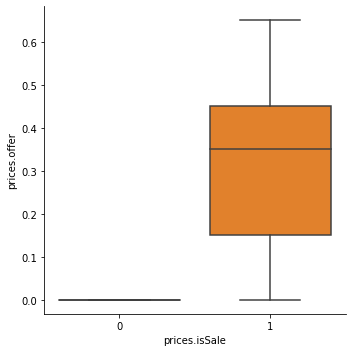

In [347]:
### Do feature engineering on sizes
# Is there any relation between isSale and price offer?
sns.catplot(x="prices.isSale", y="prices.offer", data=X_train, kind = "box")

A discount (offer) is provided only when it is on sale. Therefore, prices.isSale feature can also be removed.

In [348]:
X_train.groupby('prices.isSale')['prices.offer'].sum()

prices.isSale
0     0.00
1    36.95
Name: prices.offer, dtype: float64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text major ticklabel objects>)

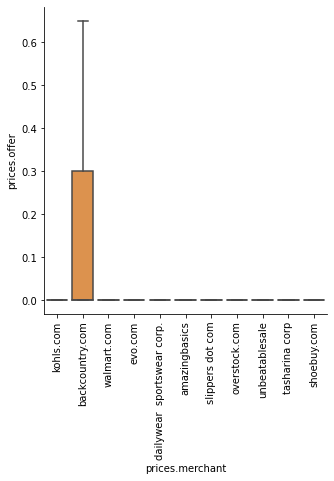

In [349]:
## Further exploration of prices.offer
# does all merchants provide sale offer?
sns.catplot(x="prices.merchant", y="prices.offer", data=X_train, kind = "box")
plt.xticks(rotation = 90)

In the data, only backcountry.com have sale offers

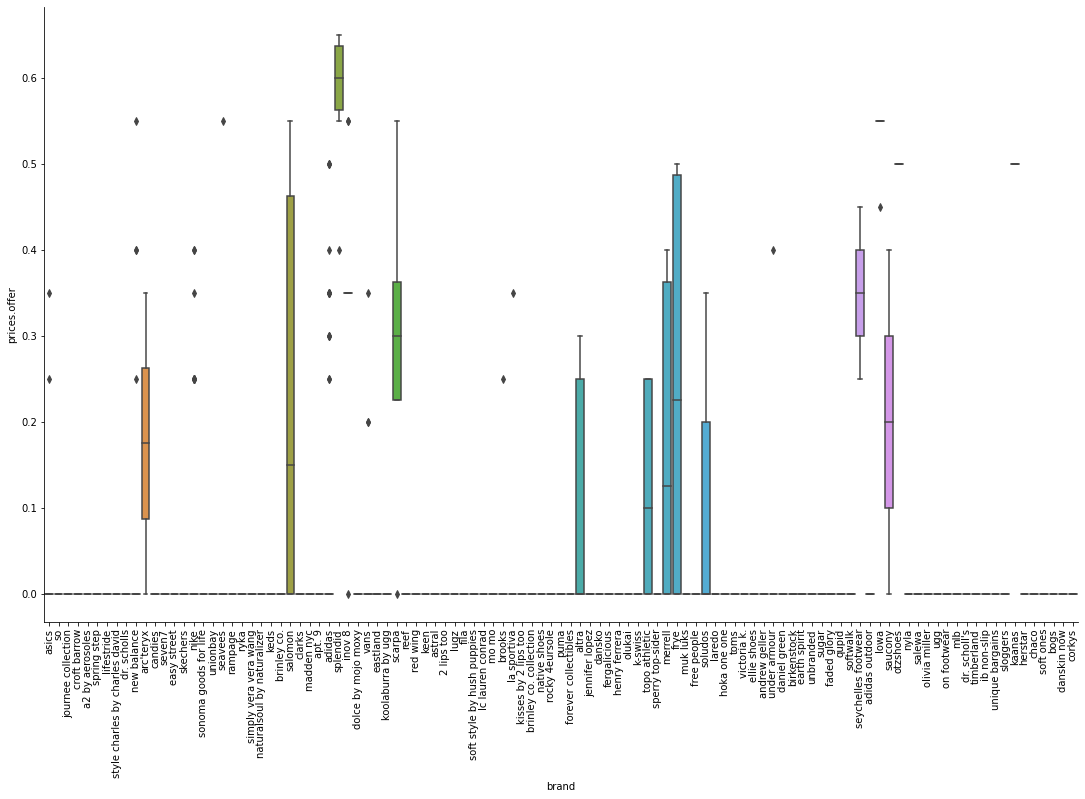

In [350]:
#plt.rcParams["figure.figsize"] = (10,20)
sns.catplot(x="brand", y="prices.offer", data=X_train, kind = "box")
_ = plt.xticks(rotation = 90)
plt.gcf().set_size_inches(20, 10)

In [351]:
X_train['prices.size'].describe(include ='all')
X_train['prices.size'].unique()

array(['8', '9', '8.5', '10 wide', '8 med', '36', '7.5 med', '6 med',
       '5.5 med', '10', '9.5 med', '8.5 med', '9.5', 'us 9.0/uk 7.5',
       '11 med', '6', '7', '9 med', '7 wide', '39', '6.5 wide', '5',
       '7 med', '11', '5 med', '9.5 wide', '7.5 wide', '12 med', '10 med',
       '11 wide', '8 wide', '6.5 med', '10.5', '6 wide', '12', '6.5',
       'us 8.0/uk 6.5', '8.5 wide', '7.5', '9 wide', '40', '5.5', '38.5',
       '11.5 wide', '42', '12 wide', '38', '35', '37', '5.5 wide',
       '10.5 med', '41', 'us 10.5/uk 9.0', 'us 9.5/uk 8.0',
       'us 10.0/uk 8.5', 's', 'mens 6.0/womens 7.5', '10.5 wide', '39.5',
       'us 7.5/uk 6.0', '38 wide', 'us 11.0/uk 9.5',
       'mens 7.0/womens 8.5', 'mens 5.5/womens 7.0', '41 wide', '40.5',
       '11.5', '5 wide', 'us 7.0/uk 5.5', 'small', 'us 6.5/uk 5.0',
       'medium', 'mens 7.5/womens 9.0', 'mens 4.5/womens 6.0', 'large',
       '41.5', 'mens 8.5/womens 10.0', 'us 6.0/uk 4.5', 'us 8.5/uk 7.0'],
      dtype=object)

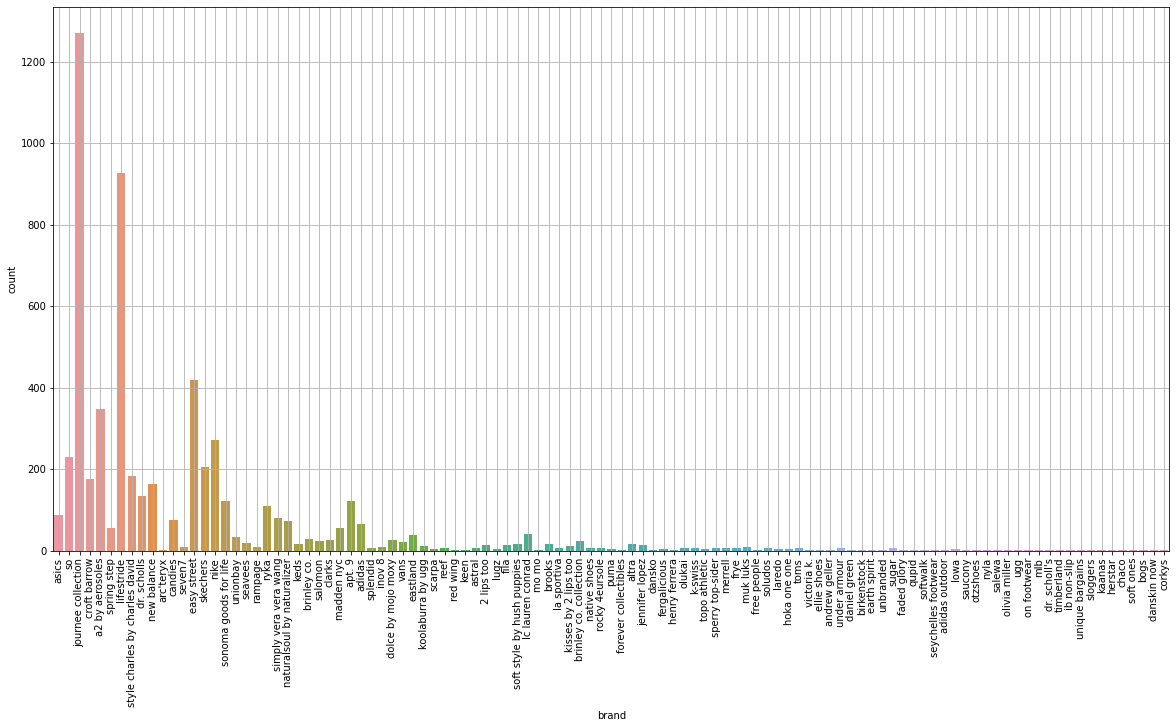

In [352]:
sns.countplot(x="brand",  data=X_train);
_ = plt.xticks(rotation = 90)
plt.gcf().set_size_inches(20, 10)
plt.grid()

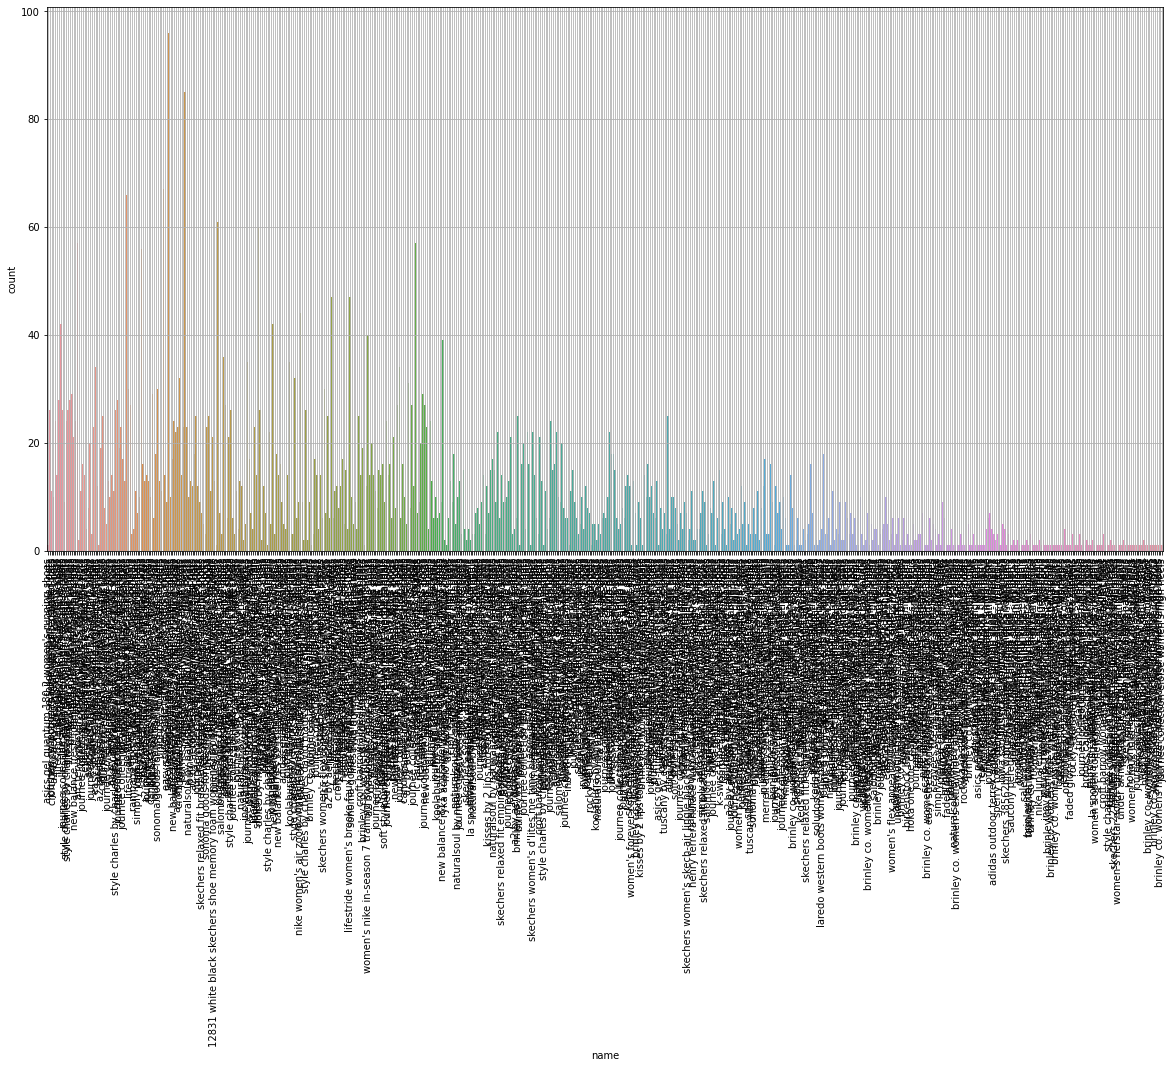

In [353]:
sns.countplot(x="name",  data=X_train);
_ = plt.xticks(rotation = 90)
plt.gcf().set_size_inches(20, 10)
plt.grid()

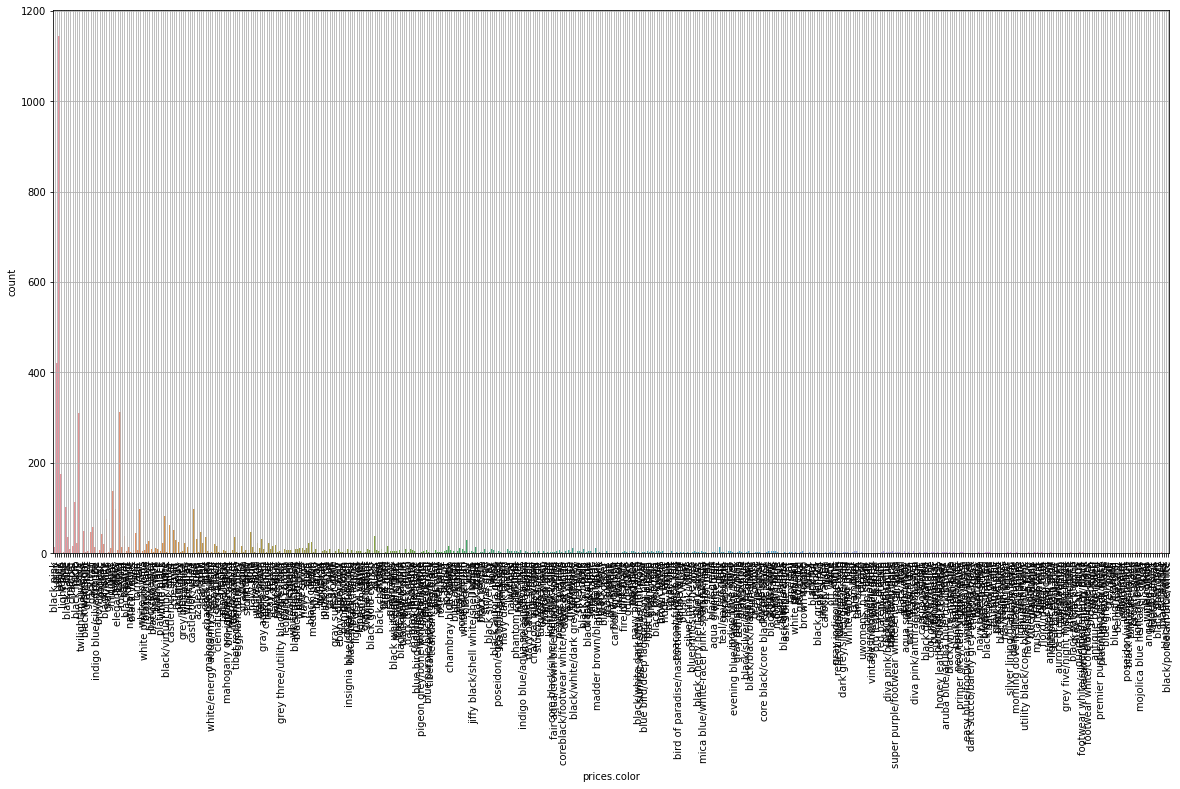

In [354]:
sns.countplot(x="prices.color",  data=X_train);
_ = plt.xticks(rotation = 90)
plt.gcf().set_size_inches(20, 10)
plt.grid()

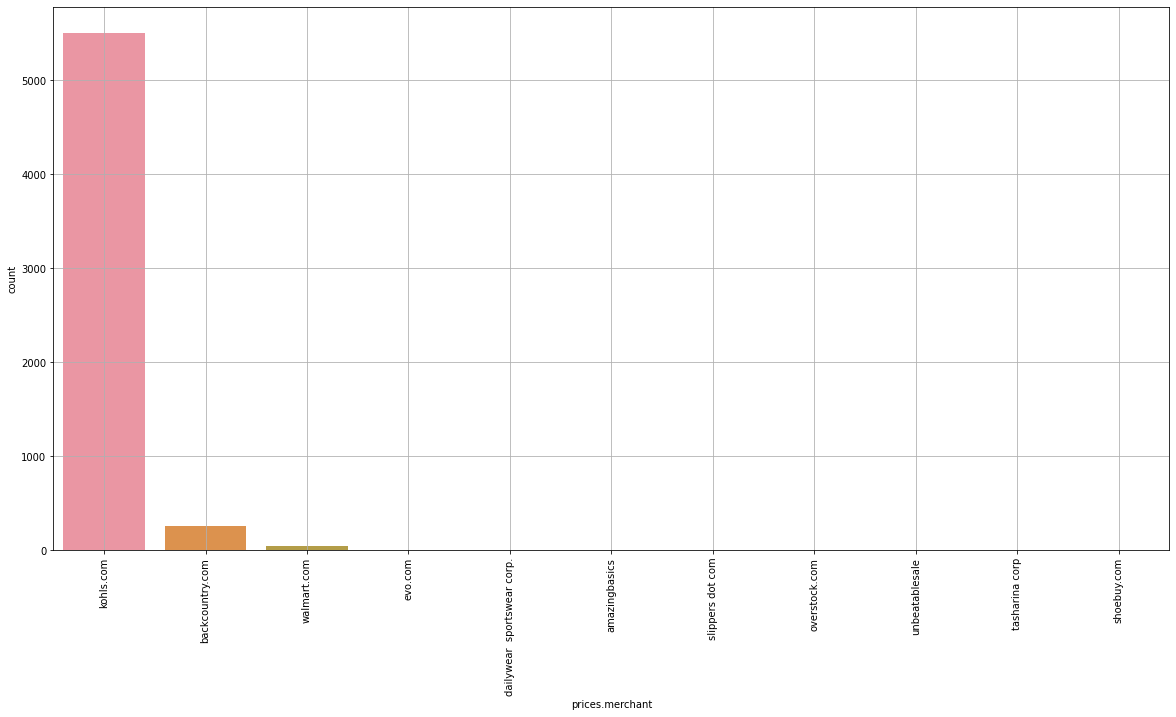

In [355]:
sns.countplot(x="prices.merchant",  data=X_train);
_ = plt.xticks(rotation = 90)
plt.gcf().set_size_inches(20, 10)
plt.grid()

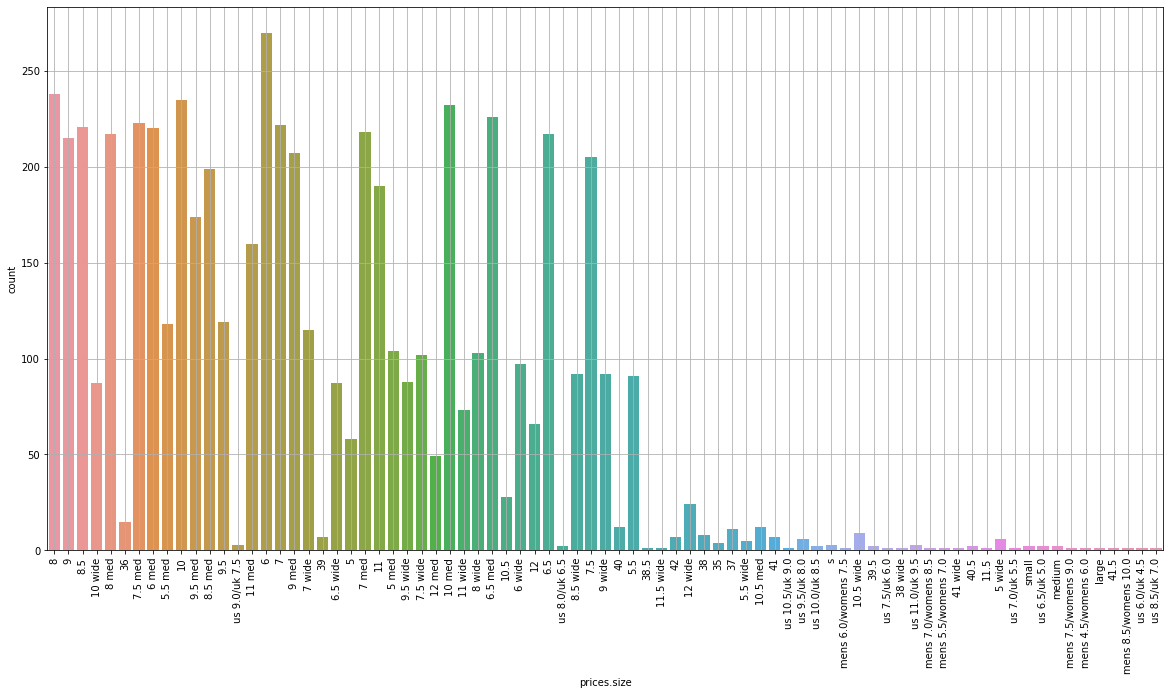

In [356]:
sns.countplot(x="prices.size",  data=X_train);
_ = plt.xticks(rotation = 90)
plt.gcf().set_size_inches(20, 10)
plt.grid()

In [357]:
X_train.drop(['prices.isSale'], axis = 1, inplace = True)

(array([5.736e+03, 1.000e+00, 0.000e+00, 2.200e+01, 9.000e+00, 1.900e+01,
        1.800e+01, 1.000e+01, 1.300e+01, 4.000e+00]),
 array([0.   , 0.065, 0.13 , 0.195, 0.26 , 0.325, 0.39 , 0.455, 0.52 ,
        0.585, 0.65 ]),
 <a list of 10 Patch objects>)

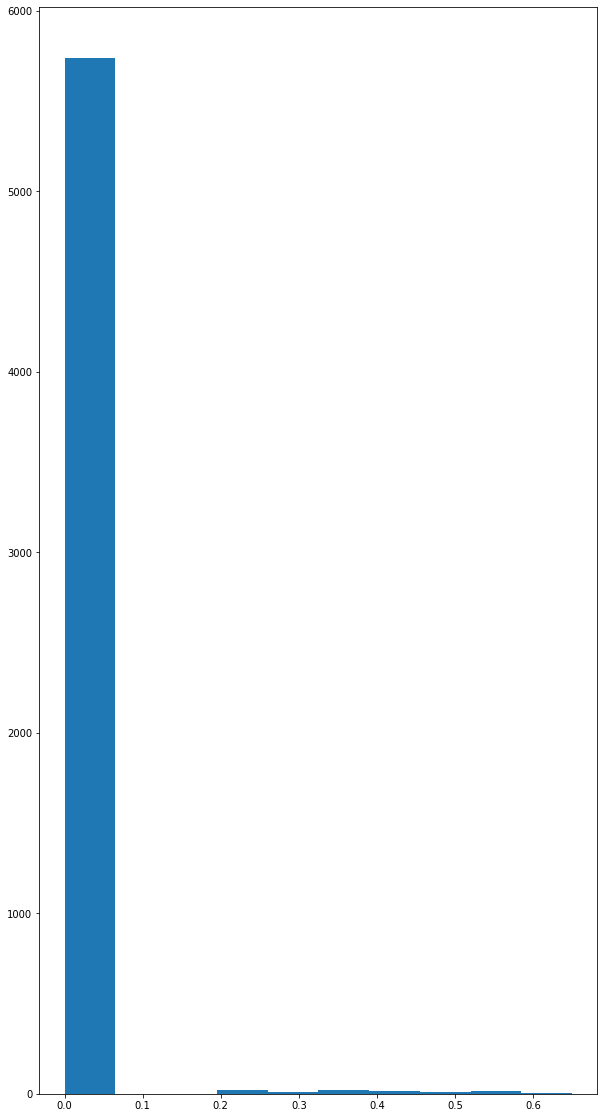

In [358]:
plt.hist(X_train['prices.offer'])

In [359]:
X_train

,brand,name,prices.color,prices.merchant,prices.size,prices.offer
9069,asics,asics gel quantum 180 2 women's running shoes,black pink,kohls.com,8,0.0
2603,so,so follow women's ankle boots,gray,kohls.com,9,0.0
7738,journee collection,journee collection marlee women's pointed flats,black,kohls.com,8.5,0.0
1579,croft barrow,croft barrow women's ortholite quilted ballet ...,black,kohls.com,10 wide,0.0
5058,a2 by aerosoles,a2 by aerosoles gravity women's ankle boots,brown,kohls.com,8 med,0.0
...,...,...,...,...,...,...
466,lifestride,lifestride eclipse women's sandals,sand,kohls.com,10 med,0.0
5734,spring step,spring step happy women's clogs,medium brown,kohls.com,39,0.0
5390,style charles by charles david,style charles by charles david groove women's ...,slate,kohls.com,10 med,0.0
860,adidas,adidas neo courtset women's suede sneakers,navy,kohls.com,6,0.0


### Preprocess of data for train and test

1. Feature elimination
2. Prices.offer: Convert None to 0.0 and divide the rest by 100
3. prices.merchant: fill na with values from prices.source -- regexed
4. lower case all object types
5. one hot encode
6. normalize

In [360]:
#preprocess of test data

narrowed_features = list(X_train.columns)
X_test['prices.merchant'] =  X_test[['prices.sourceURLs','prices.merchant']].apply(lambda x: re.findall(r'((?<=www.).+?(?=/))', x['prices.sourceURLs'])[0] if pd.isnull(x['prices.merchant']) else x['prices.merchant'], axis =1)
X_test['prices.offer'] = X_test['prices.offer'].apply(lambda x: 0.0 if pd.isnull(x) else float(x[:2])/100)
X_test[narrowed_features].select_dtypes(include='object')

,brand,name,prices.color,prices.merchant,prices.size
6252,journee collection,Journee Collection Issey Women's High Heels,Gray,kohls.com,9
4684,fila,FILA Classic Canvas Women's Casual Shoes,Gray White,kohls.com,7
1731,jennifer lopez,Jennifer Lopez Cinnabar Women's D'Orsay Flats,Red,kohls.com,8
4742,a2 by aerosoles,A2 by Aerosoles First Love Women's Dress Wedges,Black,kohls.com,5.5 MED
4521,lifestride,LifeStride Lively Women's High Heels,Black Micro,kohls.com,10 MED
...,...,...,...,...,...
8014,nike,Nike Flex Experience 6 Women's Running Shoes,Black Aurora Green,kohls.com,6.5
1074,so,SO Blog Women's Wedge Ankle Boots,Brown,kohls.com,8.5 MED
3063,dr. scholls,Dr. Scholl's Dakota Women's Wedge Ankle Boots,Black,kohls.com,8.5 WIDE
6487,journee collection,Journee Collection Ela Women's Wedge Ankle Boots,Stone,kohls.com,6.5


In [361]:
X_test_obj_types = X_test[narrowed_features].select_dtypes(include='object').apply(lambda x: x.str.lower(), axis =1)
X_test = pd.concat([X_test_obj_types, X_test[narrowed_features].select_dtypes(exclude='object')],axis =1)

In [362]:
### Data transformation classes and functions
class ColumnsSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y = None):
        return self
    def transform(self, X, y=None):
        try:
            X[self.attribute_names].shape[1]
            return X[self.attribute_names].values
        except IndexError:
            return X[self.attribute_names].values.reshape(-1,1)

In [363]:
from sklearn.preprocessing import QuantileTransformer
#separate text and other features
cat_attributes = narrowed_features[:-1]
num_attributes = narrowed_features[-1] 

pipeline_cat = Pipeline([('attributes',ColumnsSelector(cat_attributes)),
                         ('onehotencoding', OneHotEncoder(handle_unknown='ignore'))])#,                         
#                         ('standardization', StandardScaler(with_mean = False))]) 
#                         ('power-transform', QuantileTransformer())]) 
pipeline_num = Pipeline([('attributes',ColumnsSelector(num_attributes)),
                        ('standardization', StandardScaler(with_mean = False))])   
pipeline_features = FeatureUnion(transformer_list=[("categorical_features", pipeline_cat),
                                               ("numerical_feature", pipeline_num)])

In [364]:
train_data = pipeline_features.fit_transform(X_train, y_train)
test_data = pipeline_features.transform(X_test)

In [365]:
X_train

,brand,name,prices.color,prices.merchant,prices.size,prices.offer
9069,asics,asics gel quantum 180 2 women's running shoes,black pink,kohls.com,8,0.0
2603,so,so follow women's ankle boots,gray,kohls.com,9,0.0
7738,journee collection,journee collection marlee women's pointed flats,black,kohls.com,8.5,0.0
1579,croft barrow,croft barrow women's ortholite quilted ballet ...,black,kohls.com,10 wide,0.0
5058,a2 by aerosoles,a2 by aerosoles gravity women's ankle boots,brown,kohls.com,8 med,0.0
...,...,...,...,...,...,...
466,lifestride,lifestride eclipse women's sandals,sand,kohls.com,10 med,0.0
5734,spring step,spring step happy women's clogs,medium brown,kohls.com,39,0.0
5390,style charles by charles david,style charles by charles david groove women's ...,slate,kohls.com,10 med,0.0
860,adidas,adidas neo courtset women's suede sneakers,navy,kohls.com,6,0.0


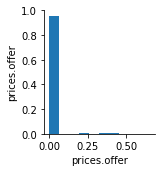

In [366]:
sns.pairplot(X_train)
#plt.scatter(X_train['prices.offer'], y_train)

In [367]:
y_train.describe()

count    5832.000000
mean       60.215737
std        19.425941
min         5.415000
25%        49.990000
50%        56.240000
75%        66.865000
max       359.950000
Name: average_price, dtype: float64

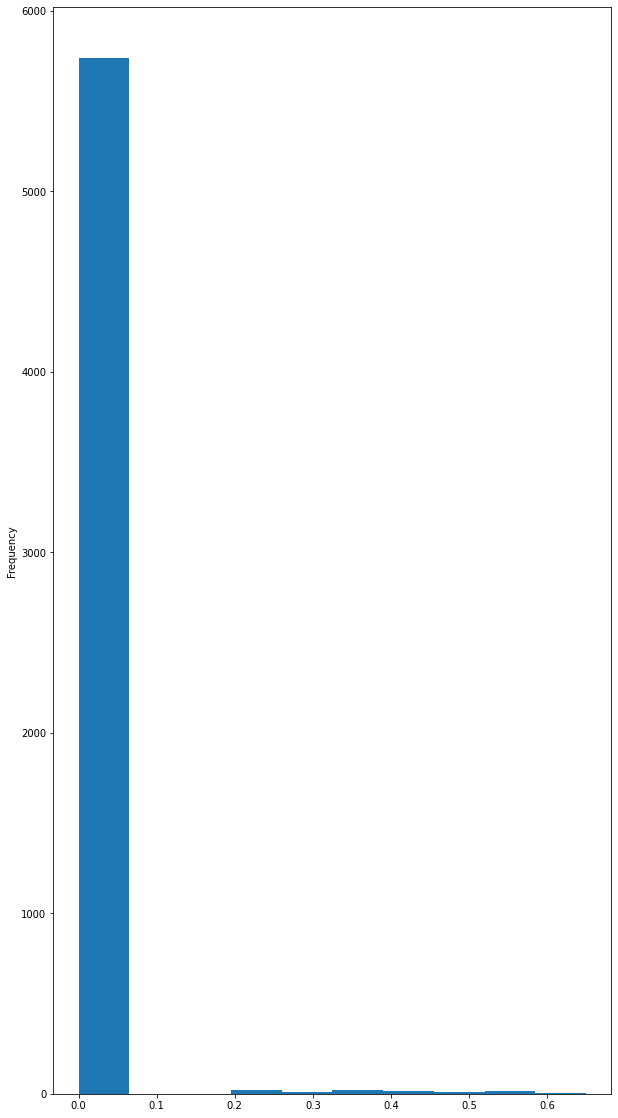

In [369]:
X_train['prices.offer'].plot(kind='hist')

60.215737311381645

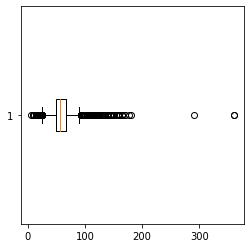

In [457]:
plt.boxplot(y_train, vert=False)
plt.gcf().set_size_inches(4, 4)
np.mean(y_train)

In [459]:
## Defining performance metric
def spot_check_model(model, trainx, trainy, score = 'neg_mean_squared_error'):
    '''Returns the mean CV score of given model. Performs cross validation with 5 splits with 3 repeats'''
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    model_score = cross_val_score(model, trainx, trainy, scoring = score, cv=cv)
    return model_score

def grid_search_cv(model, params, trainx, trainy):
    '''Performs gridsearch in the model for the given hypermaters with 5-fold CV and returns
    the best score and the fitted model best hyperparameters'''
    grid_cv = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', cv = 5, return_train_score = True)
    grid_cv.fit(trainx,trainy)
    return grid_cv, grid_cv.best_score_

def pipe_grid_search_results(model, train_x_data, y_train, test_x_data, y_test):
#def pipe_grid_search_results(classifier, test_x_data, y_test):
    '''Returns the following metrics on test data:
    Accuracy, Precision, Recall, Confusion Matrix, ROC-AUC, PR-AUC, F1-score and
    Best hyperparameters of the model. Also returns ROC-AUC of train and validation data'''
    
    model.fit(train_x_data, y_train)
    preds = model.predict(test_x_data)
    print("Mean squared error of Test data:", mean_squared_error(y_test, preds))
    print("Mean absolute error of Test data:", mean_absolute_error(y_test, preds))
    print("Mean absolute error of Test data:", r2_score(y_test, preds))
    return None

def model_evaluation(model, parameters, trainx, trainy, testx, testy):
    '''Evaluates the given model and returns the log loss scores, confusion matrix, precision
    and recall scores'''
    fit, score= grid_search_cv(model, parameters, trainx, trainy)
    print("Results:")
    print("Mean squared error of train data: ",(-1)*fit.cv_results_['mean_train_score'][fit.best_index_])
    print("Mean squared error of CV data: ",(-1)*fit.cv_results_['mean_test_score'][fit.best_index_])
    print("Best hyperparameter:", fit.best_params_)
    pipe_grid_search_results(fit, trainx, trainy, testx, testy)
    return fit  

### Modelling of data


In [371]:
### Baseline dummy model: Predicts the mean price of y_train as ouput for any query
dr = DummyRegressor()
parameters = {'strategy': ['mean', 'median']}
model_evaluation(dr, parameters, train_data, y_train, test_data, y_test)


Results:
Mean squared error of train data:  377.29459254444646
Mean squared error of CV data:  377.38276595758583
Best hyperparameter: {'strategy': 'mean'}
Mean squared error of Test data: 373.1049198860835
Mean absolute error of Test data: 12.554481570644722


GridSearchCV(cv=5, estimator=DummyRegressor(),
             param_grid={'strategy': ['mean', 'median']},
             return_train_score=True, scoring='neg_mean_squared_error')

The dummy model above (mean model) provides the baseline values for mean squared error and mean absolute error. These values will be used as benchmark to compare results from meaningful models.

In [436]:
##Transformation of target variable
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.preprocessing import FunctionTransformer

target_transform = MinMaxScaler()
target_transform.fit(y_train.values.reshape(-1, 1))
y_train_trans = target_transform.transform(y_train.values.reshape(-1, 1))
y_test_trans = target_transform.transform(y_test.values.reshape(-1, 1))

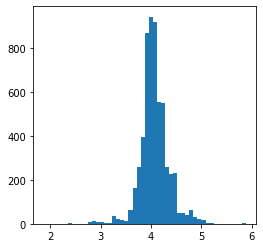

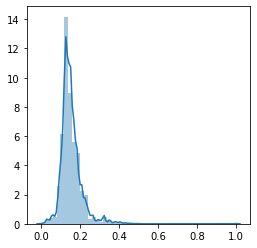

In [748]:
plt.hist(np.log1p(y_train), bins =50)
plt.gcf().set_size_inches(4, 4)
plt.show()
sns.distplot(y_train_trans)
plt.gcf().set_size_inches(4, 4)
plt.show()

In [460]:
## 1. Linear regression
lr = LinearRegression()
parameters = {'fit_intercept': [True, False]}
lr_fit = model_evaluation(lr, parameters, train_data, y_train, test_data, y_test)

Results:
Mean squared error of train data:  19.81199647333627
Mean squared error of CV data:  45.032746575456784
Best hyperparameter: {'fit_intercept': True}
Mean squared error of Test data: 35.42050712211637
Mean absolute error of Test data: 4.152677608865626
Mean absolute error of Test data: 0.9050638183347891


In [509]:
features = pipeline_features.get_params()['categorical_features']['onehotencoding'].categories_
features = np.hstack(features)
features = np.append(features, np.array(['prices.offer']))

In [516]:
lr_coefficients = pd.DataFrame(lr_fit.best_estimator_.coef_, features, columns=['Coefficient'])
lr_coefficients.sort_values(by = 'Coefficient')


,Coefficient
slippers dot com,-38.558829
new balance 247 classic shoes - women's,-38.369504
nike kawa slide womens style : 834588,-35.178164
toms,-34.753070
walmart.com,-32.684026
...,...
backcountry.com,41.681325
asics gel quantum 180 2 women's running shoes,52.155802
evo.com,54.655498
red wing harriet boots - women's,81.740525


In [547]:
X_train.groupby('name')['brand'].nunique().sort_values(ascending=False)

name
womens saddle black and pink shoes                                                           1
journee collection cairo women's lace-up high heels                                          1
journee collection dara women's high heels                                                   1
journee collection cristi women's high heels                                                 1
journee collection cortni women's pointed-toe flats                                          1
                                                                                            ..
naturalsoul by naturalizer gracee women's loafers                                            1
naturalsoul by naturalizer glamour women's ballet flats                                      1
naturalsoul by naturalizer faith women's sneakers                                            1
naturalsoul by naturalizer daya women's block heel sandals                                   1
12831 white black skechers shoe memory foam w

Every model ('name') belongs to only one brand. Thus, brand feature is redundant. We can eliminate it

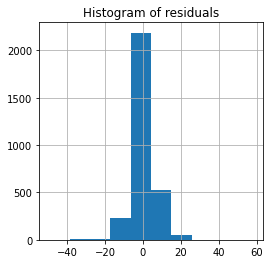

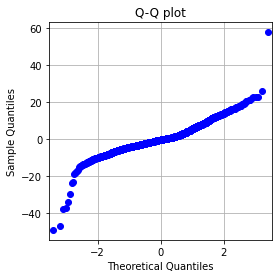

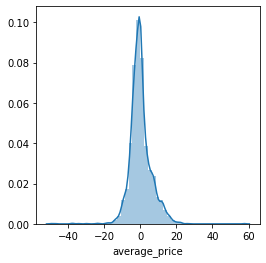

In [461]:
import statsmodels.api as sm
residual = y_test- lr_fit.predict(test_data)
plt.hist(residual)
plt.gcf().set_size_inches(4, 4)
plt.grid()
plt.title("Histogram of residuals")
prob = sm.ProbPlot(residual)
prob.qqplot()
plt.gcf().set_size_inches(4, 4)
plt.grid()
plt.title("Q-Q plot")
plt.show()
sns.distplot(residual)
plt.gcf().set_size_inches(4, 4)
#plt.hist(residual)

In [445]:
### Are the residuals are normally distributed?
from scipy.stats import shapiro
print("The test statistic from Shapiro test is {0[0]} and the p-value is {0[1]}".format(shapiro(residual)))

The test statistic from Shapiro test is 0.9249769449234009 and the p-value is 2.5194316826552502e-36


Since the p-value is <0.5, we can reject the null hypothesis that the residuals are normal

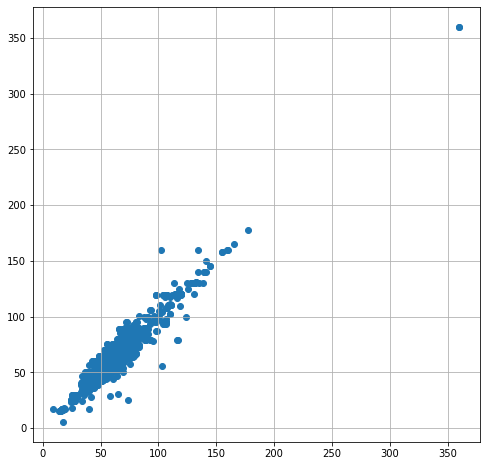

In [462]:
plt.scatter(lr_fit.predict(test_data), y_test)
plt.grid()
plt.gcf().set_size_inches(8, 8)
#plt.xlim(0,200)

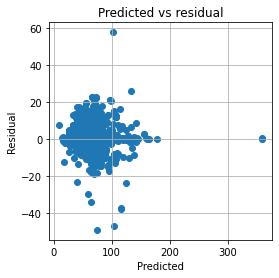

In [463]:
plt.scatter(lr_fit.predict(test_data), residual)
plt.xlabel("Predicted")
plt.ylabel("Residual")
#analysis = pd.DataFrame({'True': y_test, 'predict':lr_fit.predict(test_data)})
plt.grid()
plt.title("Predicted vs residual")
plt.gcf().set_size_inches(4, 4)
#plt.xlim(0,0.6)

{'cv': 5,
 'error_score': nan,
 'estimator__copy_X': True,
 'estimator__fit_intercept': True,
 'estimator__n_jobs': None,
 'estimator__normalize': False,
 'estimator': LinearRegression(),
 'iid': 'deprecated',
 'n_jobs': None,
 'param_grid': {'fit_intercept': [True, False]},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': True,
 'scoring': 'neg_mean_squared_error',
 'verbose': 0}

In [ ]:
analysis['residual'] = analysis['True'] - analysis['predict']
analysis.sort_values(by='residual', ascending = False)

In [ ]:
## 2. K-nearest neighbour regressor
knn = KNeighborsRegressor()
parameters = {'n_neighbors': [3,5,7,9,11,13], 'p':[1,2]}
model_evaluation(knn, parameters, train_data, y_train, test_data, y_test)

In [ ]:
X_test.loc[[9941,9832,9805,210],:]

In [ ]:
from scipy.stats import anderson
result = anderson(residual)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

In [ ]:
## 3. Linear Support Vector Machines
svm_linear = SGDRegressor()
parameters = {'alpha': [.0001,.001,.01,.1,1,10], 'l1_ratio':[0,0.1,0.15], 'fit_intercept': [True, False]}
model_evaluation(svm_linear, parameters, train_data, y_train, test_data, y_test)


In [ ]:
## 4. Non-linear Support Vector Machine
svm_nonlinear = SVR()
parameters = {'C': [.1,1,10], 'kernel':['poly', 'rbf'],}
model_evaluation(svm_nonlinear, parameters, train_data, y_train, test_data, y_test)

In [ ]:
## 5. Random Forest
rf = RandomForestRegressor()
parameters = {'n_estimators': [100, 200], 'max_depth':[2,5], 'max_features':['auto','log2']}
model_evaluation(rf, parameters, train_data, y_train, test_data, y_test)

In [ ]:
### What if sale offer is excluded? 

X_train_nooffer = X_train.drop(columns = ['prices.offer'])
X_train_nooffer

#preprocess of test data
narrowed_features = list(X_train_nooffer.columns)
X_test[narrowed_features].select_dtypes(include='object')


In [ ]:
cat_attributes = narrowed_features#[:-1]
train_data_nooffer = pipeline_features.fit_transform(X_train_nooffer, y_train)
test_data_nooffer = pipeline_features.transform(X_test)

In [ ]:
_ = plt.hist(train_data.toarray()[:,1])
np.mean(train_data.toarray()[:,1])

### Without brand feature

In [595]:
## Getting input data

cat_attributes = narrowed_features[1:-1]
num_attributes = narrowed_features[-1] 

pipeline_cat = Pipeline([('attributes',ColumnsSelector(cat_attributes)),
                         ('onehotencoding', OneHotEncoder(handle_unknown='ignore'))])#,                         
#                         ('standardization', StandardScaler(with_mean = False))]) 
#                         ('power-transform', QuantileTransformer())]) 
pipeline_num = Pipeline([('attributes',ColumnsSelector(num_attributes)),
                        ('standardization', StandardScaler(with_mean = False))])   
pipeline_features = FeatureUnion(transformer_list=[("categorical_features", pipeline_cat),
                                               ("numerical_feature", pipeline_num)])

In [596]:
train_data_nobrand = pipeline_features.fit_transform(X_train, y_train)
test_data_nobrand = pipeline_features.transform(X_test)

In [597]:
## 1. Linear regression
lr = LinearRegression()
parameters = {'fit_intercept': [True, False]}
lr_fit = model_evaluation(lr, parameters, train_data_nobrand, y_train, test_data_nobrand, y_test)

Results:
Mean squared error of train data:  19.81199647334599
Mean squared error of CV data:  59.474281028998476
Best hyperparameter: {'fit_intercept': True}
Mean squared error of Test data: 37.52585767199777
Mean absolute error of Test data: 4.235626829143266
Mean absolute error of Test data: 0.8994209306826332


In [598]:
features = pipeline_features.get_params()['categorical_features']['onehotencoding'].categories_
features = np.hstack(features)
features = np.append(features, np.array(['prices.offer']))
lr_coefficients = pd.DataFrame(lr_fit.best_estimator_.coef_, features, columns=['Coefficient'])
lr_coefficients.sort_values(by = 'Coefficient')

,Coefficient
new balance 247 classic shoes - women's,-78.053846
sperry top-sider sayel away washed shoe - women's,-56.050813
toms venice alpargata shoe - women's,-52.049920
bogs sweet pea slip on shoe - women's,-50.208740
seavees baja standard slip on shoe - women's,-47.171112
...,...
black boundary,66.424197
mahogany oro-iginal leather,66.833189
asics gel quantum 180 2 women's running shoes,72.266226
evo.com,84.993729


### Fixing size feature

In [588]:
X_train['prices.size'].unique()

array(['8', '9', '8.5', '10 wide', '8 med', '36', '7.5 med', '6 med',
       '5.5 med', '10', '9.5 med', '8.5 med', '9.5', 'us 9.0/uk 7.5',
       '11 med', '6', '7', '9 med', '7 wide', '39', '6.5 wide', '5',
       '7 med', '11', '5 med', '9.5 wide', '7.5 wide', '12 med', '10 med',
       '11 wide', '8 wide', '6.5 med', '10.5', '6 wide', '12', '6.5',
       'us 8.0/uk 6.5', '8.5 wide', '7.5', '9 wide', '40', '5.5', '38.5',
       '11.5 wide', '42', '12 wide', '38', '35', '37', '5.5 wide',
       '10.5 med', '41', 'us 10.5/uk 9.0', 'us 9.5/uk 8.0',
       'us 10.0/uk 8.5', 's', 'mens 6.0/womens 7.5', '10.5 wide', '39.5',
       'us 7.5/uk 6.0', '38 wide', 'us 11.0/uk 9.5',
       'mens 7.0/womens 8.5', 'mens 5.5/womens 7.0', '41 wide', '40.5',
       '11.5', '5 wide', 'us 7.0/uk 5.5', 'small', 'us 6.5/uk 5.0',
       'medium', 'mens 7.5/womens 9.0', 'mens 4.5/womens 6.0', 'large',
       '41.5', 'mens 8.5/womens 10.0', 'us 6.0/uk 4.5', 'us 8.5/uk 7.0'],
      dtype=object)

- **remove men's sizes**: This prediction is only on women's shoes
- **convert all sizes to US size**: Convert everything to one unit - US size. Remove UK size and convert European to US
- **convert wide and med?**: Should wide and medium be another column?

In [633]:
## reference: https://en.wikipedia.org/wiki/Shoe_size; table name: European shoe size conversion
shoe_size= pd.read_clipboard()
shoe_size

,EUR,US women
0,34.0,4.0
1,34.5,4.5
2,35.0,5.0
3,35.5,5.5
4,36.0,6.0
5,36.5,6.0
6,37.0,6.5
7,37.5,7.0
8,38.0,7.5
9,38.5,7.5


In [656]:
shoe_size = shoe_size.astype('str')
shoe_size.set_index('EUR', inplace = True)

In [657]:
eur_us_conv = shoe_size.to_dict()['US women']

In [696]:
def fix_shoe_size(x):
    if "men" in x:
        x = re.findall( r'[0-9]*.[0-9]$',x)[0]
    elif "us" in x:
        x = re.findall( r'(?<=us )[0-9]*.[0-9](?=/)',x)[0]
    elif "small" in x:
        x = "s"
    elif "medium" in x:
        x = "m"
    elif "large" in x:
        x = "l"
    if "." not in x.split()[0]:
        try:
            x = x.split()[0] + ".0" + " " + x.split()[1]
        except IndexError:
            x = x.split()[0] + ".0"
    if x.split()[0] in eur_us_conv:
        try: 
            return eur_us_conv[x.split()[0]] + " " + x.split()[1]
        except:
            return eur_us_conv[x.split()[0]]
    else:
        return x
fix_shoe_size('large')

'l.0'

In [772]:
X_train['prices.size'] = X_train['prices.size'].apply(lambda x : fix_shoe_size(x))
X_test['prices.size'] = X_test['prices.size'].apply(lambda x : fix_shoe_size(x))

In [773]:
cat_attributes = narrowed_features[1:-1]
num_attributes = narrowed_features[-1] 

pipeline_cat = Pipeline([('attributes',ColumnsSelector(cat_attributes)),
                         ('onehotencoding', OneHotEncoder(handle_unknown='ignore'))])                     
pipeline_num = Pipeline([('attributes',ColumnsSelector(num_attributes)),
                        ('power-transform', PowerTransformer())]) 
#                        ('standardization', StandardScaler(with_mean = False))])   
pipeline_features = FeatureUnion(transformer_list=[("categorical_features", pipeline_cat),
                                               ("numerical_feature", pipeline_num)])
    

In [774]:
train_data_nobrand_csize = pipeline_features.fit_transform(X_train, y_train)
test_data_nobrand_csize = pipeline_features.transform(X_test)

In [775]:
## 1. Linear regression with transformed prices.offer
lr = LinearRegression()
parameters = {'fit_intercept': [True, False]}
lr_fit = model_evaluation(lr, parameters, train_data_nobrand_csize, y_train, test_data_nobrand_csize, y_test)


Results:
Mean squared error of train data:  19.823851850114558
Mean squared error of CV data:  61.29187368155101
Best hyperparameter: {'fit_intercept': True}
Mean squared error of Test data: 37.066780952958446
Mean absolute error of Test data: 4.2244398611360765
Mean absolute error of Test data: 0.9006513758212848


In [776]:
features = pipeline_features.get_params()['categorical_features']['onehotencoding'].categories_
features = np.hstack(features)
features = np.append(features, np.array(['prices.offer']))
lr_coefficients = pd.DataFrame(lr_fit.best_estimator_.coef_, features, columns=['Coefficient'])
lr_coefficients.sort_values(by = 'Coefficient')

,Coefficient
new balance 247 classic shoes - women's,-78.472805
sperry top-sider sayel away washed shoe - women's,-54.036434
toms venice alpargata shoe - women's,-50.615467
bogs sweet pea slip on shoe - women's,-48.164522
slippers dot com,-47.337259
...,...
black boundary,66.233536
mahogany oro-iginal leather,66.646848
asics gel quantum 180 2 women's running shoes,71.763306
evo.com,83.612462


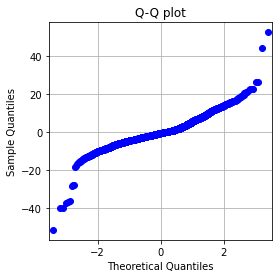

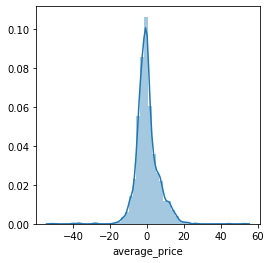

In [777]:
residual = y_test- lr_fit.predict(test_data_nobrand_csize)
prob = sm.ProbPlot(residual)
prob.qqplot()
plt.gcf().set_size_inches(4, 4)
plt.grid()
plt.title("Q-Q plot")
plt.show()
sns.distplot(residual)
plt.gcf().set_size_inches(4, 4)
#plt.hist(residual)

(0.0, 200.0)

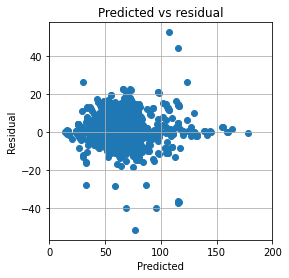

In [778]:
plt.scatter(lr_fit.predict(test_data_nobrand_csize), residual)
plt.xlabel("Predicted")
plt.ylabel("Residual")
#analysis = pd.DataFrame({'True': y_test, 'predict':lr_fit.predict(test_data)})
plt.grid()
plt.title("Predicted vs residual")
plt.gcf().set_size_inches(4, 4)
plt.xlim(0,200)

In [779]:
print("The test statistic from Shapiro test is {0[0]} and the p-value is {0[1]}".format(shapiro(residual)))

The test statistic from Shapiro test is 0.9193792343139648 and the p-value is 2.3817677179460225e-37


In [714]:
X_train.groupby(['brand', 'name', 'prices.color', 'prices.size', 'prices.offer'])['prices.merchant'].nunique().sort_values(ascending =False)

brand               name                                                                       prices.color  prices.size  prices.offer
muk luks            muk luks womens jane suede moccasin                                        grey          6.0          0.0             2
victoria k.         victoria k. women's fashion chain link strap sandal                        red           6.0          0.0             1
journee collection  journee collection darby women's sandals                                   blue          10.0         0.0             1
                    journee collection dara women's high heels                                 gray          11.0 med     0.0             1
                                                                                                             9.0 med      0.0             1
                                                                                                                                         ..
lifestride          lifes

In [715]:
X_train[X_train['name'] == 'muk luks womens jane suede moccasin']

,brand,name,prices.color,prices.merchant,prices.size,prices.offer
2,muk luks,muk luks womens jane suede moccasin,grey,slippers dot com,6.0,0.0
1,muk luks,muk luks womens jane suede moccasin,grey,walmart.com,6.0,0.0


In [780]:
# 1. Linear regression with regularization: SGD Regressor
sgd = SGDRegressor()
parameters = {'fit_intercept': [True, False], 'penalty': ['l1', 'l2'],
              'alpha':[0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1, 10, 100]}
sgd_fit = model_evaluation(sgd, parameters, train_data_nobrand_csize, y_train, test_data_nobrand_csize, y_test)

Results:
Mean squared error of train data:  39.74400180911901
Mean squared error of CV data:  83.05565541132471
Best hyperparameter: {'alpha': 0, 'fit_intercept': True, 'penalty': 'l2'}
Mean squared error of Test data: 51.80341978467407
Mean absolute error of Test data: 4.8702780691481
Mean absolute error of Test data: 0.8611533467151797


In [735]:
# 1. Linear regression with regularization: SGD Regressor
rf = RandomForestRegressor()
parameters = {'n_estimators': [100,300,500], 'max_depth': [None, 15, 10], 
              'max_features': ['auto', 'sqrt', 'log2']}
rf_fit = model_evaluation(rf, parameters, train_data_nobrand_csize, y_train, test_data_nobrand_csize, y_test)

Results:
Mean squared error of train data:  11.235622762000578
Mean squared error of CV data:  79.37918128659688
Best hyperparameter: {'max_depth': None, 'max_features': 'auto', 'n_estimators': 500}
Mean squared error of Test data: 48.20672296465114
Mean absolute error of Test data: 4.624467459365087
Mean absolute error of Test data: 0.8707934306790589


In [843]:
from sklearn.preprocessing import FunctionTransformer

target_transform = FunctionTransformer(np.log1p, validate=True)
target_transform.fit(y_train.values.reshape(-1, 1))
y_train_trans = target_transform.transform(y_train.values.reshape(-1, 1))
y_test_trans = target_transform.transform(y_test.values.reshape(-1, 1))

In [844]:
### Log transformed y with brand removed and size fixed

## 1. Linear regression with transformed prices.offer
lr = LinearRegression()
parameters = {'fit_intercept': [True, False]}
lr_fit = model_evaluation(lr, parameters, train_data_nobrand_csize, y_train_trans, test_data_nobrand_csize, y_test_trans)

Results:
Mean squared error of train data:  0.0051061141611909635
Mean squared error of CV data:  0.01348222564210511
Best hyperparameter: {'fit_intercept': True}
Mean squared error of Test data: 0.009719928512234586
Mean absolute error of Test data: 0.0694247132166655
Mean absolute error of Test data: 0.8799186817306779


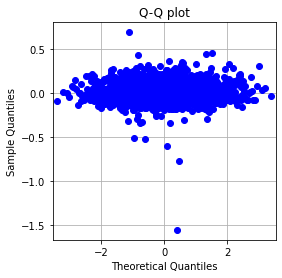

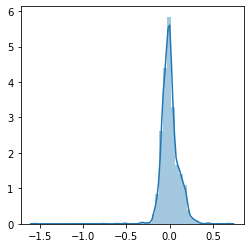

In [845]:
residual = y_test_trans- lr_fit.predict(test_data_nobrand_csize)
prob = sm.ProbPlot(residual)
prob.qqplot()
plt.gcf().set_size_inches(4, 4)
plt.grid()
plt.title("Q-Q plot")
plt.show()
sns.distplot(residual)
plt.gcf().set_size_inches(4, 4)
#plt.hist(residual)

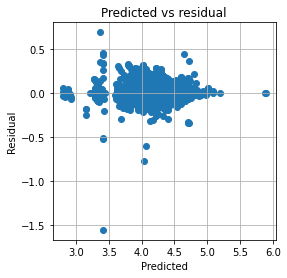

In [846]:
plt.scatter(lr_fit.predict(test_data_nobrand_csize), residual)
plt.xlabel("Predicted")
plt.ylabel("Residual")
#analysis = pd.DataFrame({'True': y_test, 'predict':lr_fit.predict(test_data)})
plt.grid()
plt.title("Predicted vs residual")
plt.gcf().set_size_inches(4, 4)
#plt.xlim(0,200)

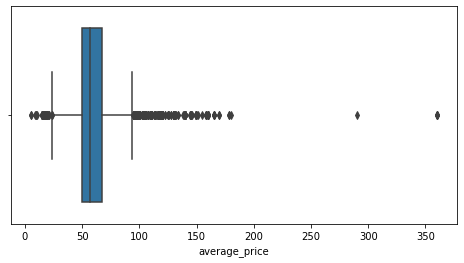

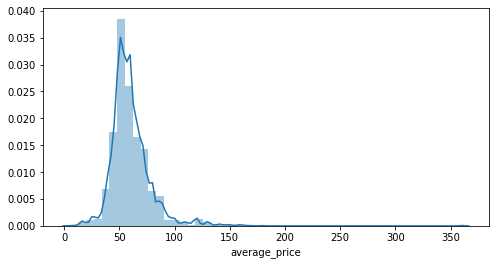

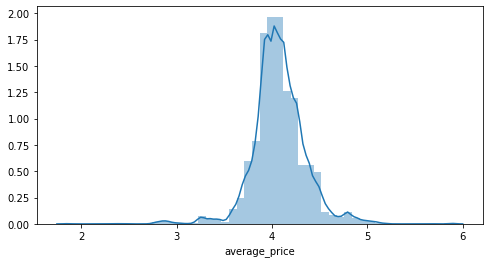

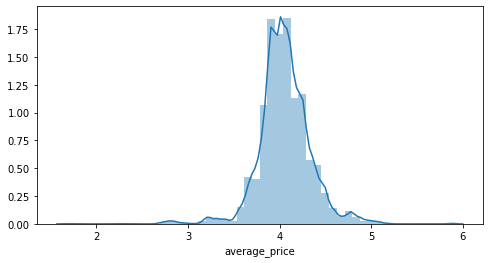

In [847]:
sns.boxplot(df.average_price)
plt.gcf().set_size_inches(8, 4)
plt.show()
_ = sns.distplot(df.average_price)
plt.gcf().set_size_inches(8, 4)
plt.show()
_ = sns.distplot(np.log1p(df.average_price))
plt.gcf().set_size_inches(8, 4)
plt.show()
_ = sns.distplot(np.log(df.average_price))
plt.gcf().set_size_inches(8, 4)

0.8799186817306779


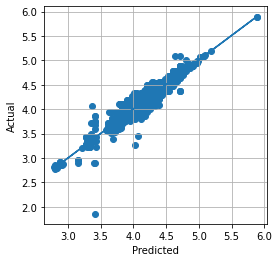

In [848]:
predicted = lr_fit.predict(test_data_nobrand_csize)
curve_fit = LinearRegression(fit_intercept=True)
curve_fit.fit(predicted, y_test_trans)
slope = curve_fit.coef_
intercept = curve_fit.intercept_
print(r2_score(y_test_trans, predicted))
plt.scatter(predicted, y_test_trans)
plt.plot(predicted,slope*predicted+intercept)
plt.gcf().set_size_inches(4, 4)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.grid(which = 'both')


In [849]:
### No brand, prices.offer, csize, y transformed (np.log1p)
cat_attributes = narrowed_features[1:-1]
#num_attributes = narrowed_features[-1] 

pipeline_cat = Pipeline([('attributes',ColumnsSelector(cat_attributes)),
                         ('onehotencoding', OneHotEncoder(handle_unknown='ignore'))])                     
# pipeline_num = Pipeline([('attributes',ColumnsSelector(num_attributes)),
#                         ('power-transform', PowerTransformer())]) 

# pipeline_features = FeatureUnion(transformer_list=[("categorical_features", pipeline_cat),
#                                                ("numerical_feature", pipeline_num)])
    

In [851]:
train_data_nobrandoffer_csize = pipeline_cat.fit_transform(X_train, y_train)
test_data_nobrandoffer_csize = pipeline_cat.transform(X_test)

In [853]:
## 1. Linear regression
lr = LinearRegression()
parameters = {'fit_intercept': [True, False]}
lr_fit = model_evaluation(lr, parameters, train_data_nobrandoffer_csize, y_train_trans, test_data_nobrandoffer_csize, y_test_trans)

Results:
Mean squared error of train data:  0.005117957279290694
Mean squared error of CV data:  0.013634587040650098
Best hyperparameter: {'fit_intercept': True}
Mean squared error of Test data: 0.009775160457231815
Mean absolute error of Test data: 0.06967796570988308
Mean absolute error of Test data: 0.8792363387733714


In [855]:
X_train

,brand,name,prices.color,prices.merchant,prices.size,prices.offer
9069,asics,asics gel quantum 180 2 women's running shoes,black pink,kohls.com,8.0,0.0
2603,so,so follow women's ankle boots,gray,kohls.com,9.0,0.0
7738,journee collection,journee collection marlee women's pointed flats,black,kohls.com,8.5,0.0
1579,croft barrow,croft barrow women's ortholite quilted ballet ...,black,kohls.com,10.0 wide,0.0
5058,a2 by aerosoles,a2 by aerosoles gravity women's ankle boots,brown,kohls.com,8.0 med,0.0
...,...,...,...,...,...,...
466,lifestride,lifestride eclipse women's sandals,sand,kohls.com,10.0 med,0.0
5734,spring step,spring step happy women's clogs,medium brown,kohls.com,8.0,0.0
5390,style charles by charles david,style charles by charles david groove women's ...,slate,kohls.com,10.0 med,0.0
860,adidas,adidas neo courtset women's suede sneakers,navy,kohls.com,6.0,0.0
